In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import NuestrasFunciones

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
    
from sklearn.experimental import enable_iterative_imputer
import sklearn.impute as skl_imp
import feature_engine.imputation as fe_imp


from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20, 12)

### "NuestrasFunciones" es un módulo hecho por nuestro profesor, le hice cambios en plot() y la función get_cat_corr_mat() la introduje yo.

### Al trabajo aún le falta modelado manual, usé el sequential feature selector y pca para tener un benchmark que mejorar.

In [79]:
df_fuga_sinObj = pd.read_csv("In/FugaClientes_Test.csv")
df_fuga = pd.read_csv("In/FugaClientes_Training.csv")

<Axes: >

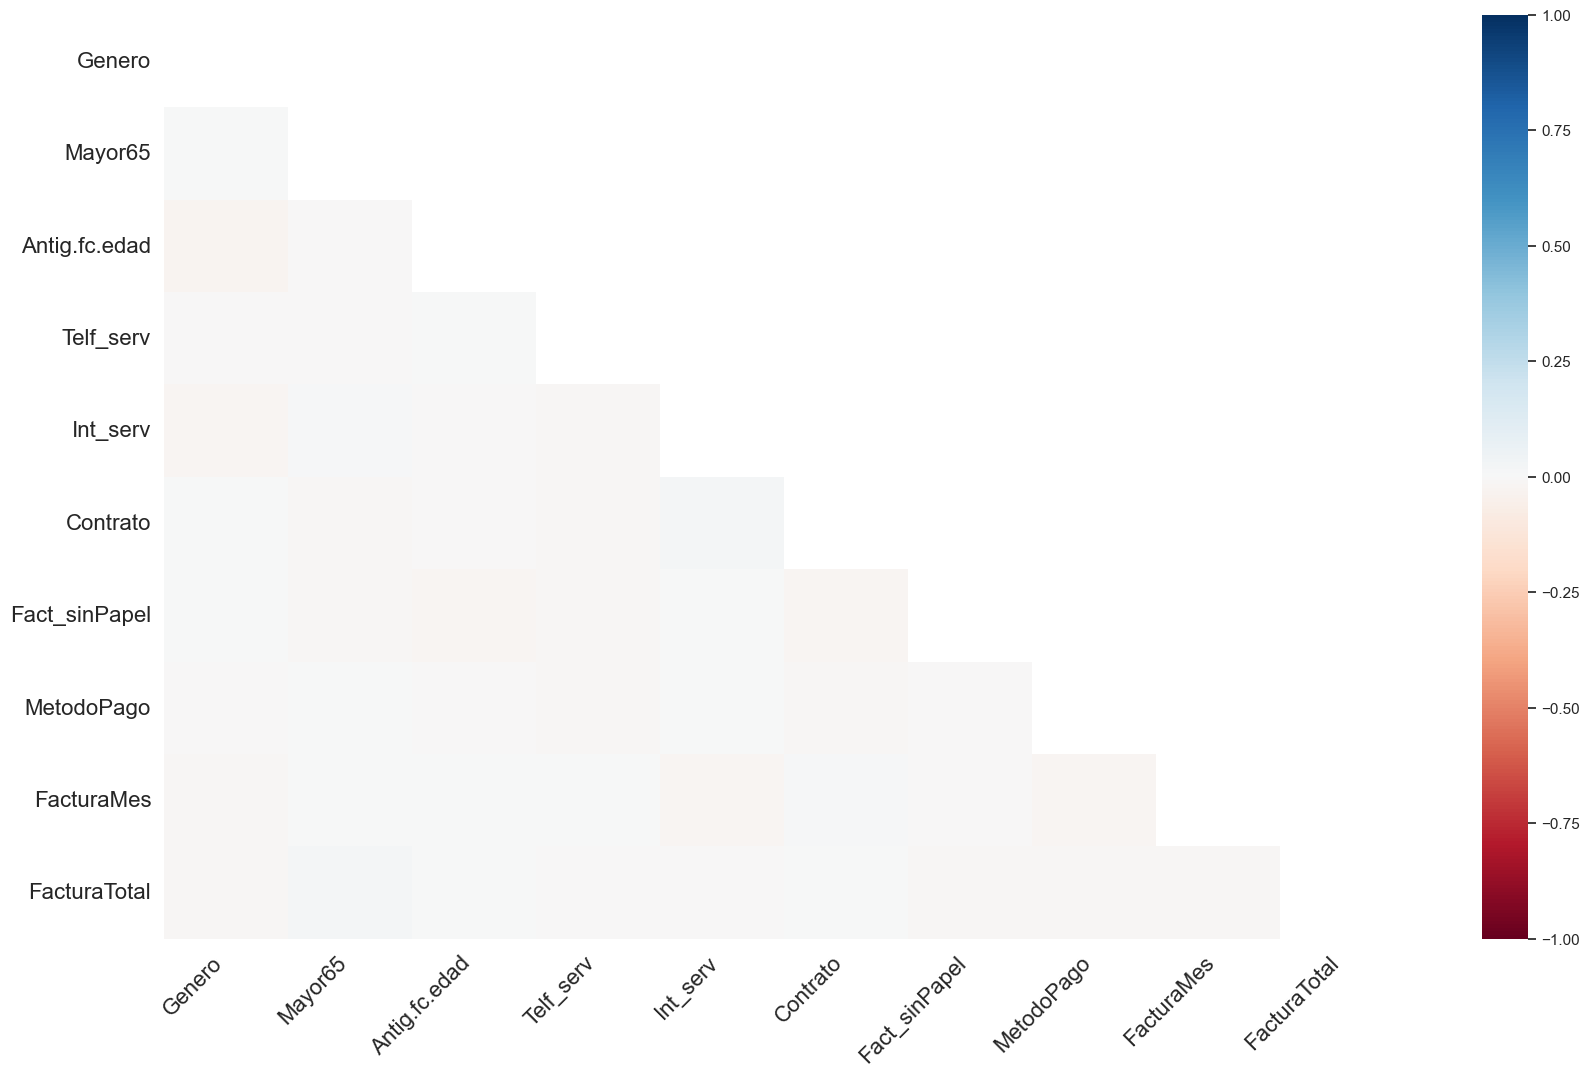

In [80]:
import missingno as msno 
msno.heatmap(df_fuga)

### No hay correlación entre mis missings. En vez de crear una columna de missings por cada variable que las presente, crearé una con proporción de missings por observación.

Cat


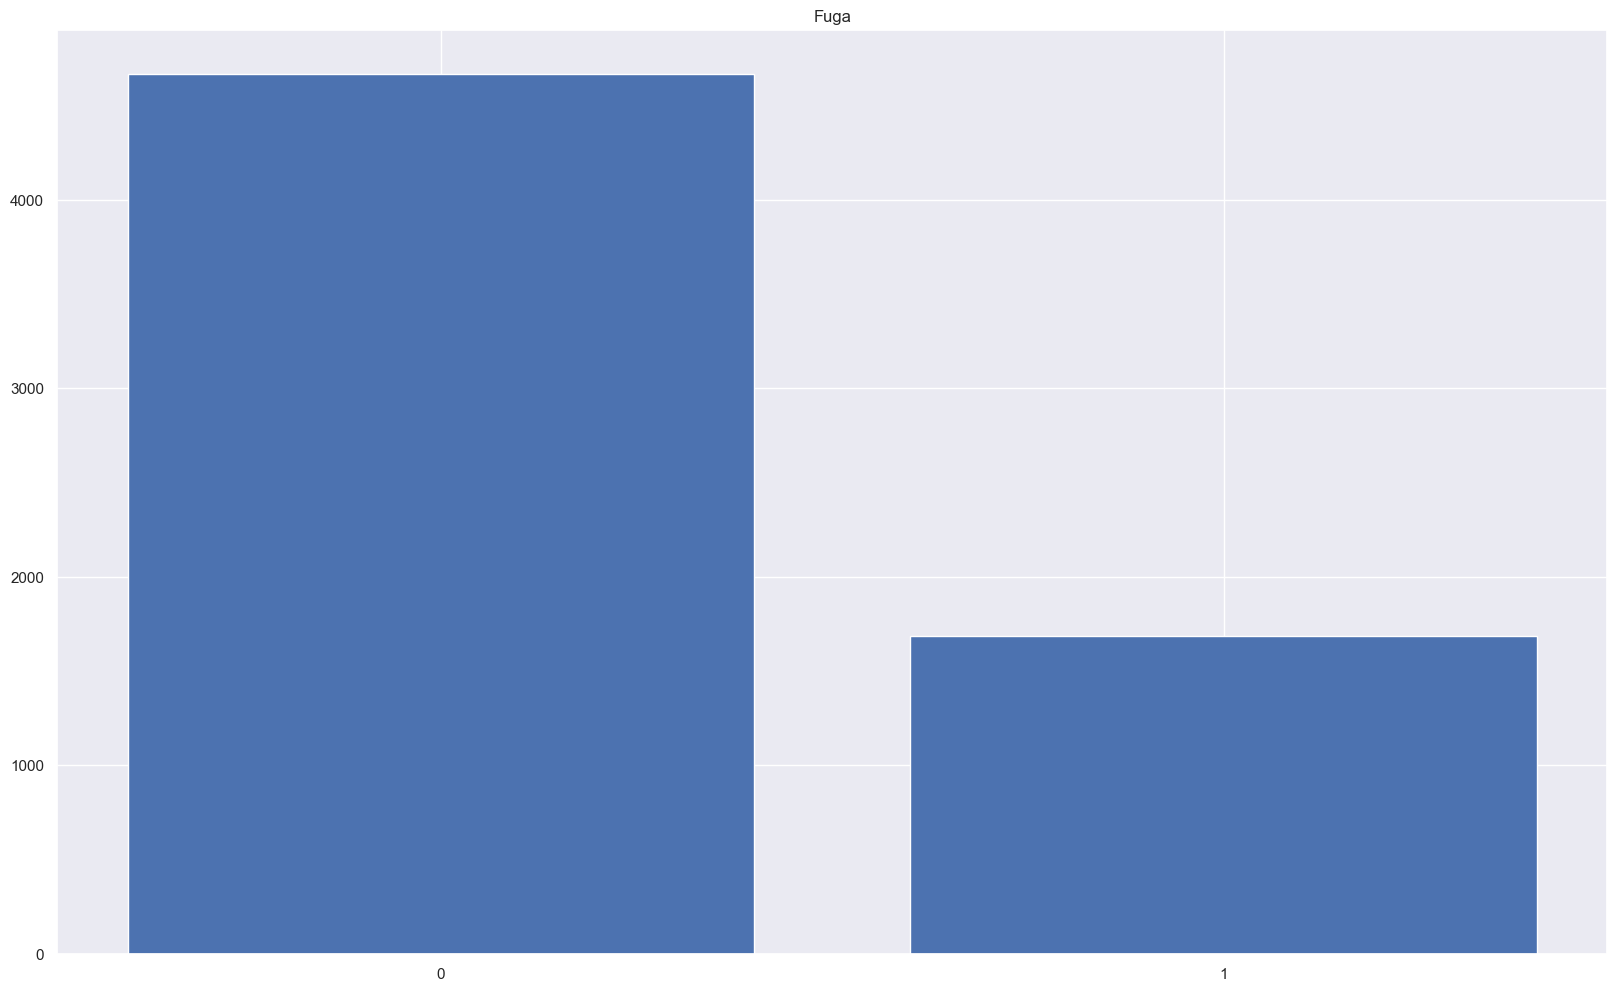

In [81]:
NuestrasFunciones.plot(df_fuga.Fuga.astype("category")) 

### Es importante hacer un train-test así como cross validation estratificado debido a la menor prevalencia de 1s que de 0s

In [82]:
def columna_missing(df,tipo = "individual"):
    """
    si tipo individual crea una por variable que contenga missings, 
    si tipo agg crea una columna prop missings que indica proporcion de fila que es NA.
    """

    if tipo == "individual":
        #select_dtypes(include=np.number)
        for cols in df.columns:
            if df[cols].isnull().values.any():
                nombre = cols + "_esNA"
                df[nombre] = df[cols].apply(lambda x: 1 if pd.isnull(x) else 0)
    elif tipo == "agg":
        #df_fuga["proportion_missing"] = df_fuga.apply(lambda x: x.isna().sum() / x.size * 100, axis = 1)
        df["missing_count"] = df.apply(lambda x: x.isna().sum(), axis = 1)

def no_yes_dicotom(df):
    for col in df.columns:
        if set(df[col].value_counts().index).issuperset(["No", "Yes"]):
            df.loc[df[col] == "No", col] = 0 
            df.loc[df[col] == "Yes", col] = 1
        
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class Clenaner(BaseEstimator, TransformerMixin):
    
    def __init__(self, tipo = "individual"): 
        self.tipo = tipo
        
    def fit(self, X, y=None):
        return self 
        
    def transform(self,X,y = None):
        X.rename(columns = {"Antig.fc.edad": "meses_antiguedad"},inplace = True)
        X.drop("ID",axis = 1,inplace = True)

        X.loc[X["Genero"] == "Male", "Genero"] = 0 
        X.loc[X["Genero"] == "Female", "Genero"] = 1
        
        no_yes_dicotom(X)
        columna_missing(X, tipo = "agg")
        
        to_factor = list(X.loc[:,X.nunique() <= 4]);  
        X[to_factor] = X[to_factor].astype('category')

        
        return X

In [83]:
def tipos(df, todos = False):
    X_dicotom = []
    X_cat = []
    X_cont = []
    
    for cols in df.columns:
        es_digito = df[cols].value_counts(dropna = True)
        es_digito = [True if np.issubdtype(type(x), np.number) else False for x in es_digito.index]
        if all(es_digito):
            if df[cols].nunique() <= 2:
                X_dicotom.append(cols)
            elif df[cols].nunique() > 2:
                X_cont.append(cols)
        else:
            X_cat.append(cols)
    if todos:
        return X_cont,X_cat,X_dicotom,df.columns
        
    else:
        return X_cont,X_cat,X_dicotom
                 
#uno,dos,tres = tipos(X)

class Imputador(BaseEstimator, TransformerMixin):



    def __init__(self, neighbors = False):
        self.neighbors = neighbors

    
    def fit(self, X, y=None):
        #print("hizo fit")
        self.X_cont,self.X_cat,self.X_dicotom = tipos(X)
        
        self.imputer_moda = skl_imp.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        self.imputer_random = fe_imp.RandomSampleImputer()
        
        self.imputer_moda.fit(X[self.X_dicotom])
        self.imputer_random.fit(X[self.X_cat])

        
        return self 
    
    def transform(self, X, y=None):
        #print("una")
       # print(self.X_cat)
       # print("-------------------")
        self.X_cont,self.X_cat,self.X_dicotom = tipos(X)
        
        self.imputer_random.transform(X[self.X_cat])
        self.X_cat = pd.DataFrame(self.imputer_random.transform(X[self.X_cat]),columns = self.X_cat)#,columns = self.X_cat
        self.X_dicotom = pd.DataFrame(self.imputer_moda.transform(X[self.X_dicotom]),columns = self.X_dicotom)
        
        if self.neighbors:
            imputer_knn = skl_imp.KNNImputer(n_neighbors=self.neighbors)
            self.X_cont = pd.DataFrame(imputer_knn.fit_transform(X[self.X_cont]),columns=self.X_cont)
            
        else:
            imputer_iterativo = skl_imp.IterativeImputer(max_iter=10, random_state=1234)
            self.X_cont = pd.DataFrame(imputer_iterativo.fit_transform(X[self.X_cont]),columns = self.X_cont)

        X = pd.concat([self.X_cont,self.X_cat,self.X_dicotom], axis = 1)
        
        return X

In [84]:
class myScaler(BaseEstimator,TransformerMixin): 
    def fit(self, X, y=None):
        self.escalador = StandardScaler()
        
        self.X_cont,self.X_cat,self.X_dicotom = tipos(X)
        
        self.scaled = X[self.X_cont]
        self.constant = X[self.X_cat+self.X_dicotom]
        
        self.escalador.fit(self.scaled)
        
        return self

    def transform(self, X, y=None, copy=None):
        self.scaled = X[self.X_cont]
        self.constant = X[self.X_cat+self.X_dicotom]
        self.scaled = pd.DataFrame(self.escalador.transform(self.scaled),columns = self.X_cont)

        return pd.concat([self.scaled, self.constant], axis=1)

class myDummifier(BaseEstimator,TransformerMixin): 
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None, copy=None):
        self.X_cont,self.X_cat,self.X_dicotom = tipos(X)
        
        return pd.get_dummies(X, drop_first = True, columns = self.X_cat)

In [85]:
from sklearn.model_selection import StratifiedShuffleSplit

#df_fuga = pd.read_csv("FugaClientes_Training.csv")
#df_Y = pd.DataFrame(df_fuga.Fuga)


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_index, test_index in split.split(df_fuga, df_fuga["Fuga"]):
        train_set = df_fuga.loc[train_index].reset_index().drop("index",axis = 1)
        test_set = df_fuga.loc[test_index].reset_index().drop("index",axis = 1)

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
    
from sklearn.experimental import enable_iterative_imputer
import sklearn.impute as skl_imp
import feature_engine.imputation as fe_imp


pipep = Pipeline([
            ("limpa",Clenaner()),
            ('imputa', Imputador(neighbors = False)),
            ('escala', myScaler()),
            ("dumifica", myDummifier())
        ])


df_train = pipep.fit_transform(train_set.copy())
df_test = pipep.transform(test_set.copy())
df_fuga_preparado = pipep.fit_transform(df_fuga.copy())
df_fuga_final = pipep.fit_transform(df_fuga_sinObj.copy())
df_fuga_final.rename(columns = {"Antiguedad": "meses_antiguedad"},inplace = True)

In [87]:
df_fuga_preparado.to_csv("Out/df_fuga_completo.csv", index = False)
df_train.to_csv("Out/df_fuga_train.csv", index = False)
df_test.to_csv("Out/df_fuga_test.csv", index = False)
df_fuga_final.to_csv("Out/df_fuga_Y_final.csv", index = False)

In [88]:
"""
df_fuga_preparado = pd.read_csv("df_fuga_preparado.csv")
to_factor = list(df_fuga_preparado.loc[:,df_fuga_preparado.nunique() <= 4]);  
df_fuga_preparado[to_factor] = df_fuga_preparado[to_factor].astype('category')
"""

df_fuga_train = pd.read_csv("Out/df_fuga_train.csv")
to_factor = list(df_fuga_train.loc[:,df_fuga_train.nunique() <= 4]);  
df_fuga_train[to_factor] = df_fuga_train[to_factor].astype('category')



df_fuga_test = pd.read_csv("Out/df_fuga_test.csv")
to_factor = list(df_fuga_test.loc[:,df_fuga_test.nunique() <= 4]);  
df_fuga_test[to_factor] = df_fuga_test[to_factor].astype('category')


Y_train =df_fuga_train.Fuga
Y_test = df_fuga_test.Fuga

df_fuga_train.drop("Fuga",axis = 1,inplace = True)
df_fuga_test.drop("Fuga",axis = 1,inplace = True)

Cont


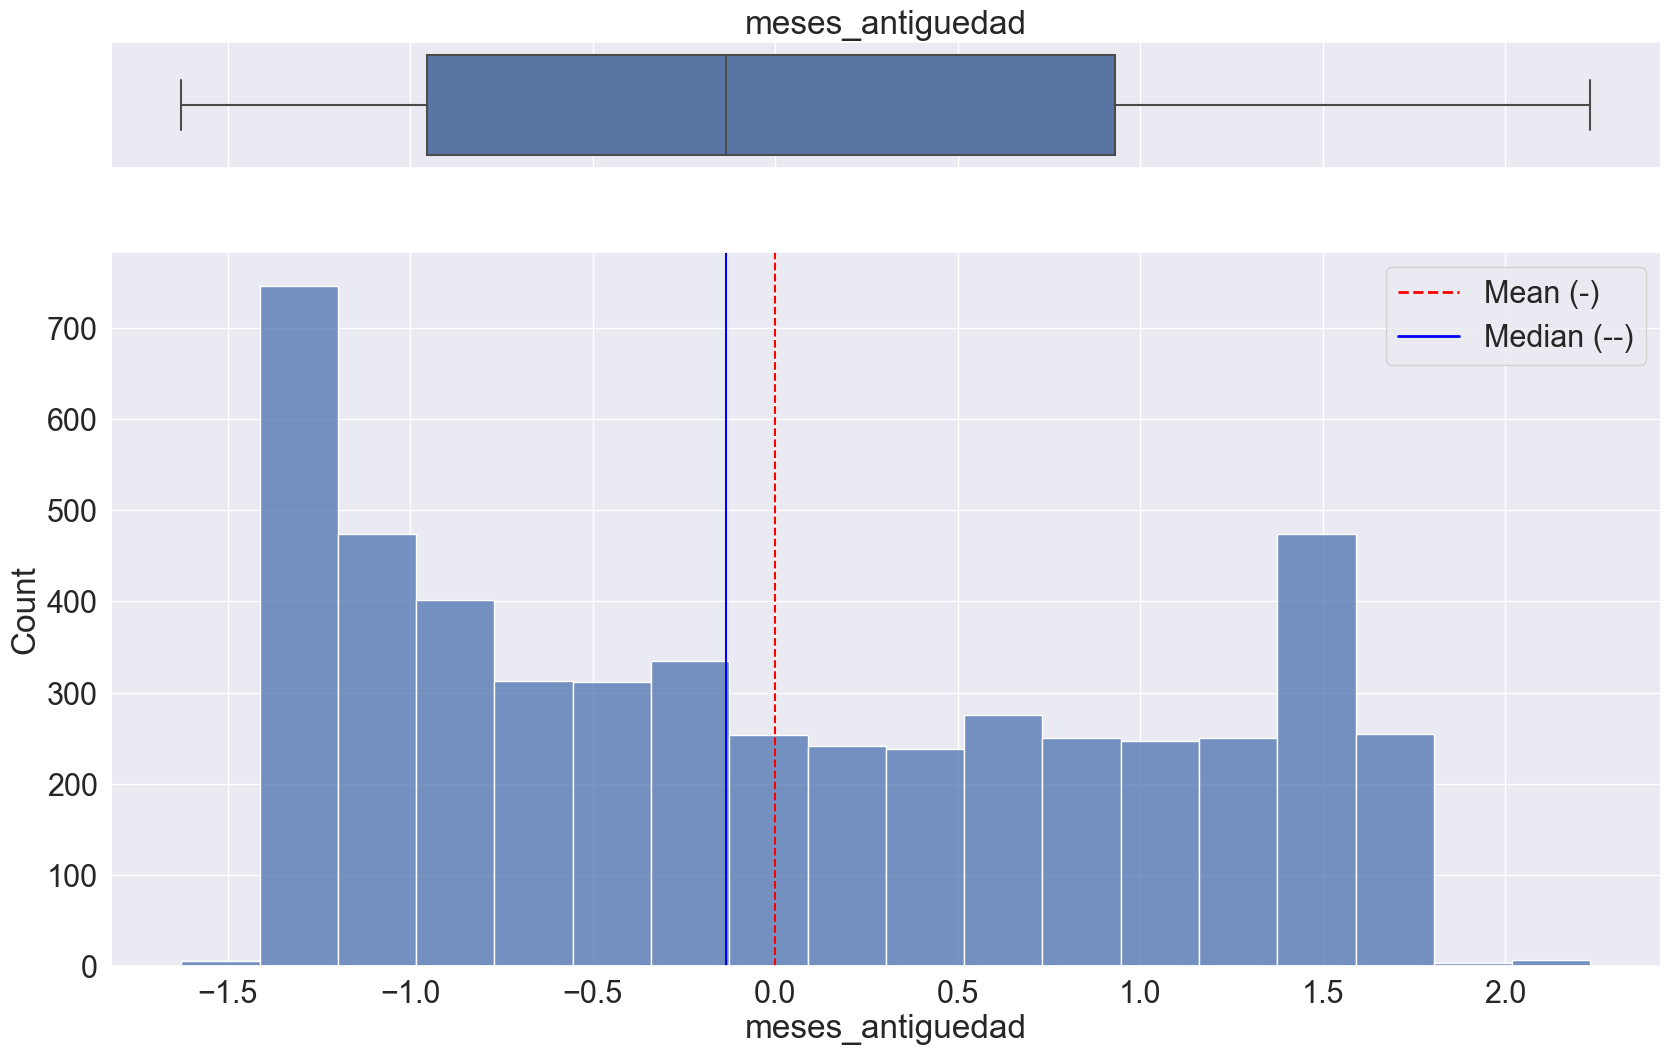

Cont


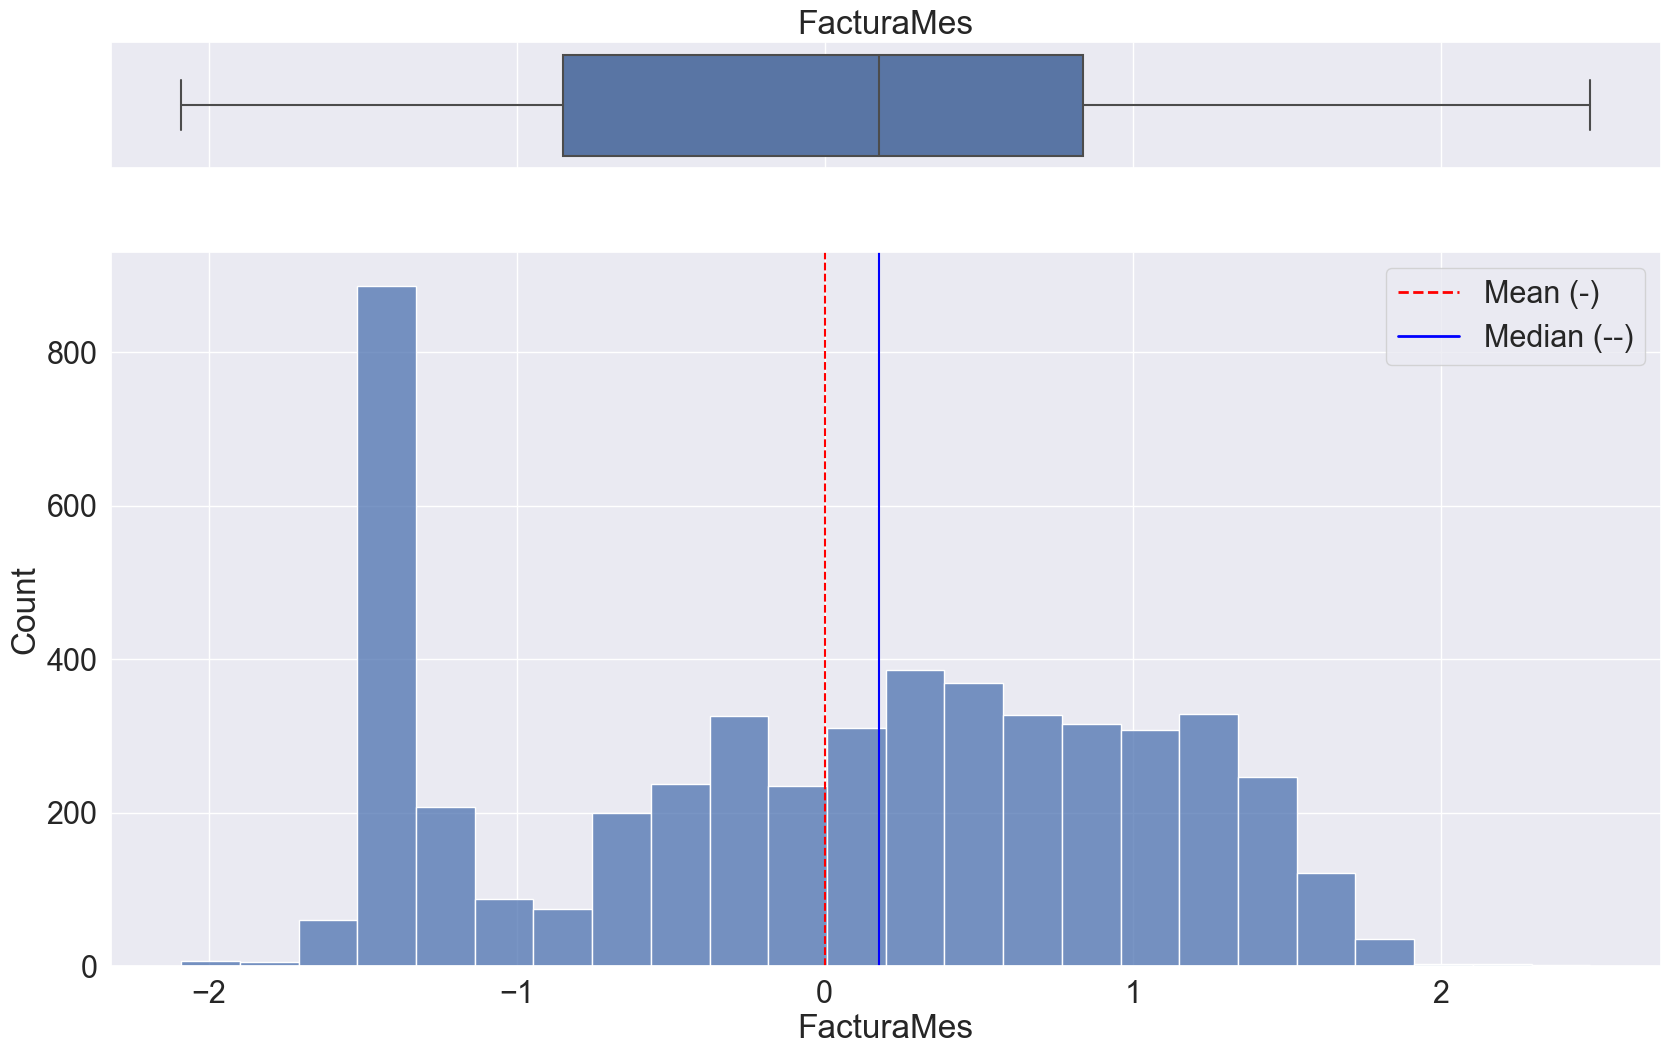

Cont


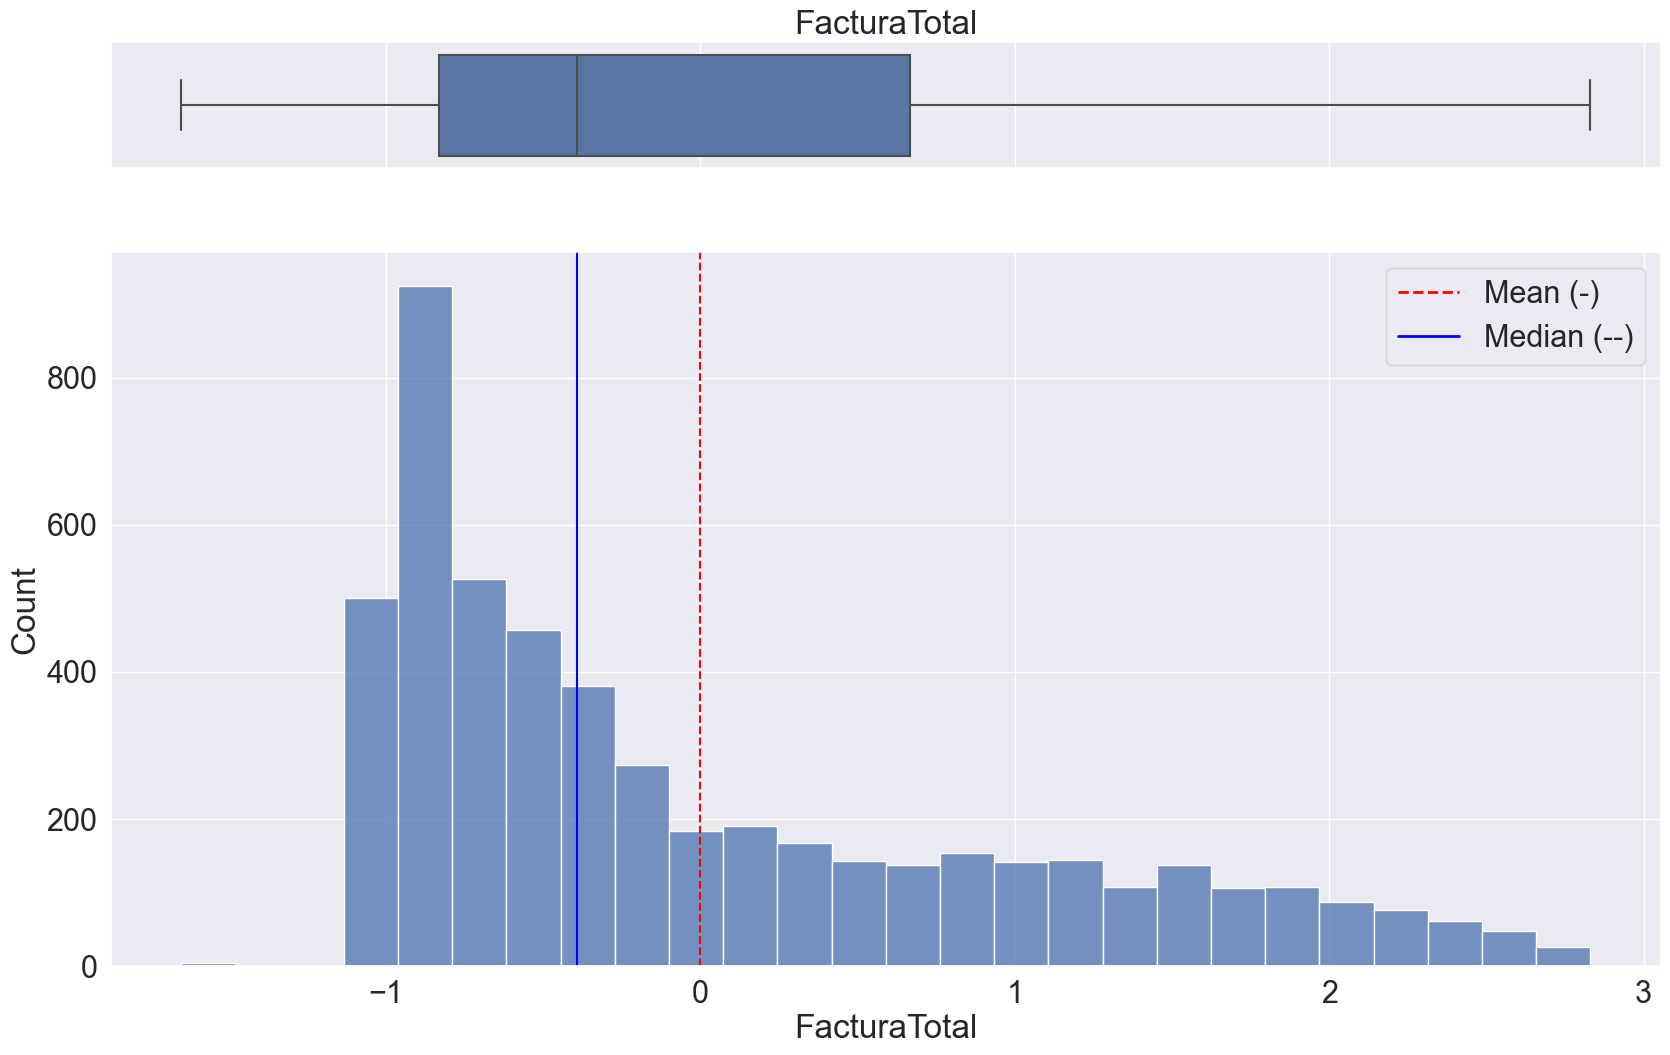

Cat


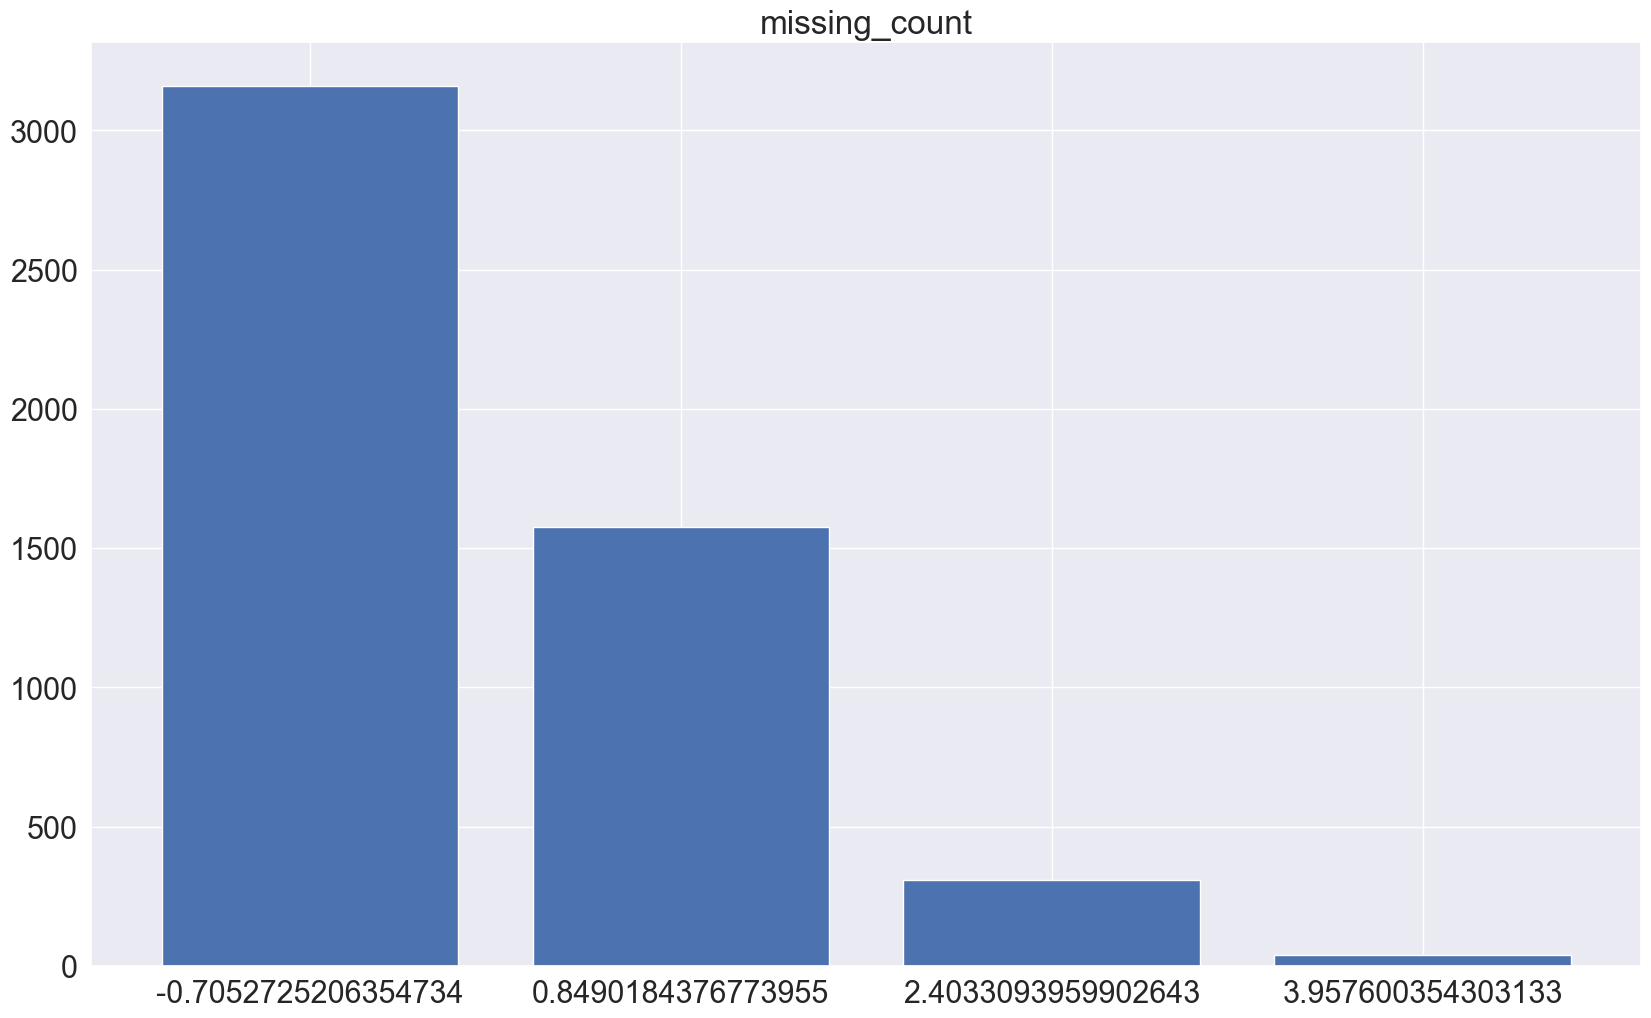

Cat


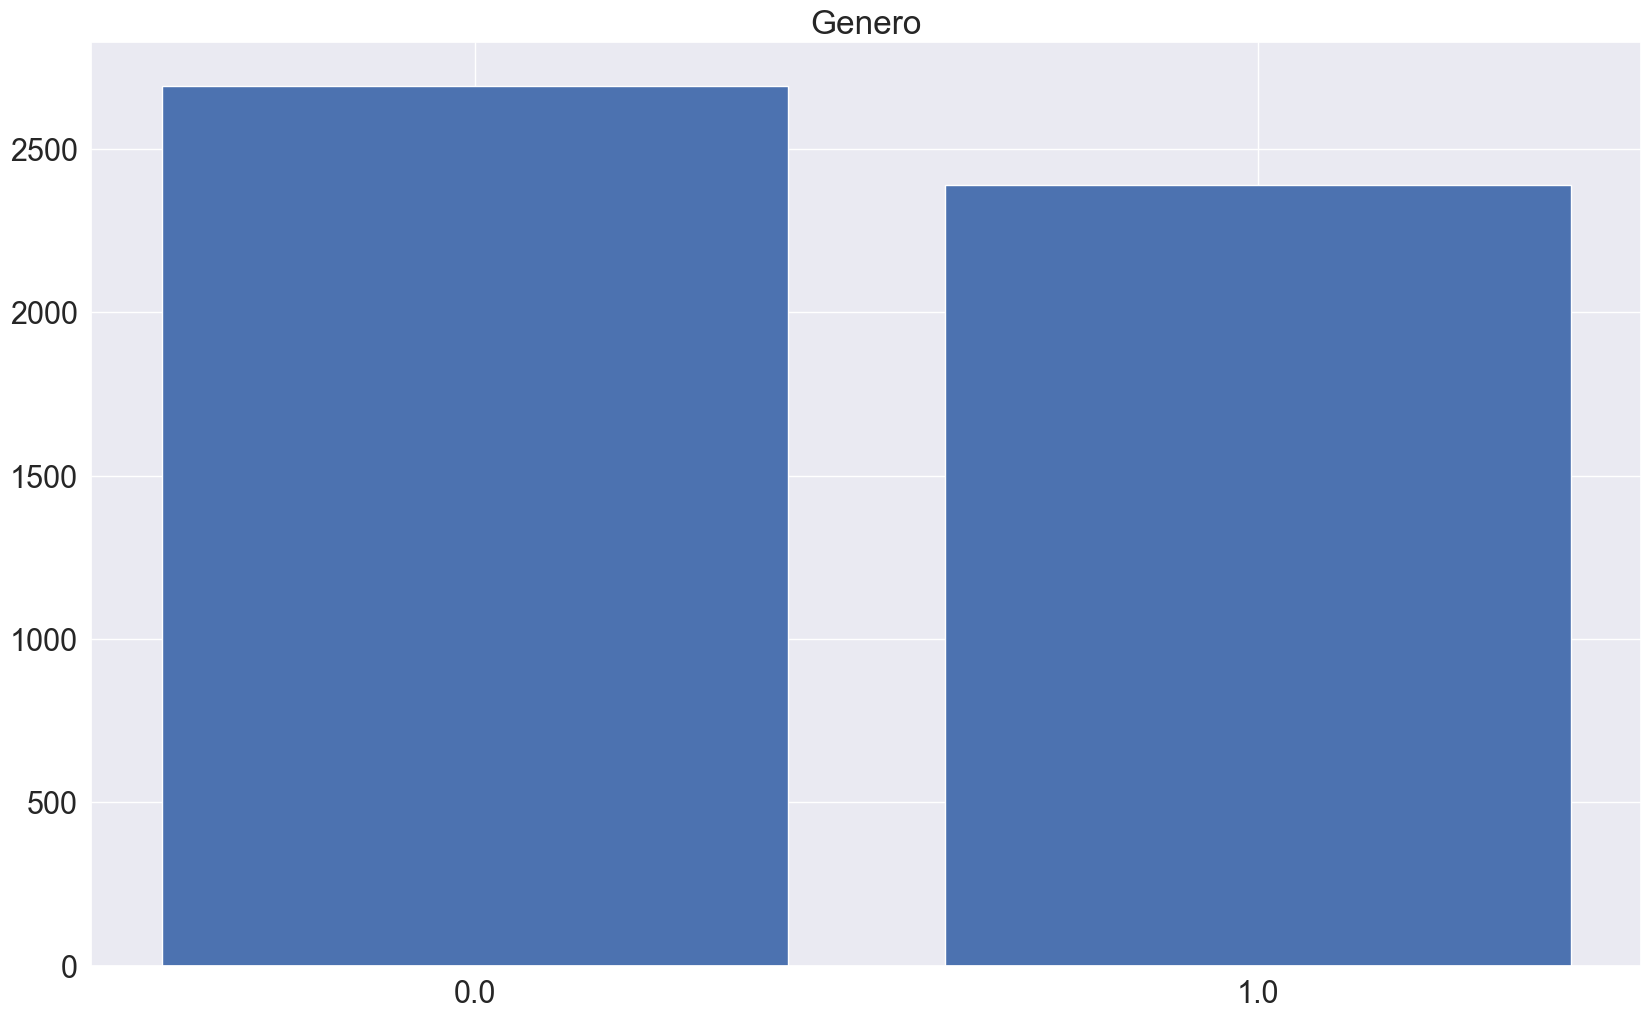

Cat


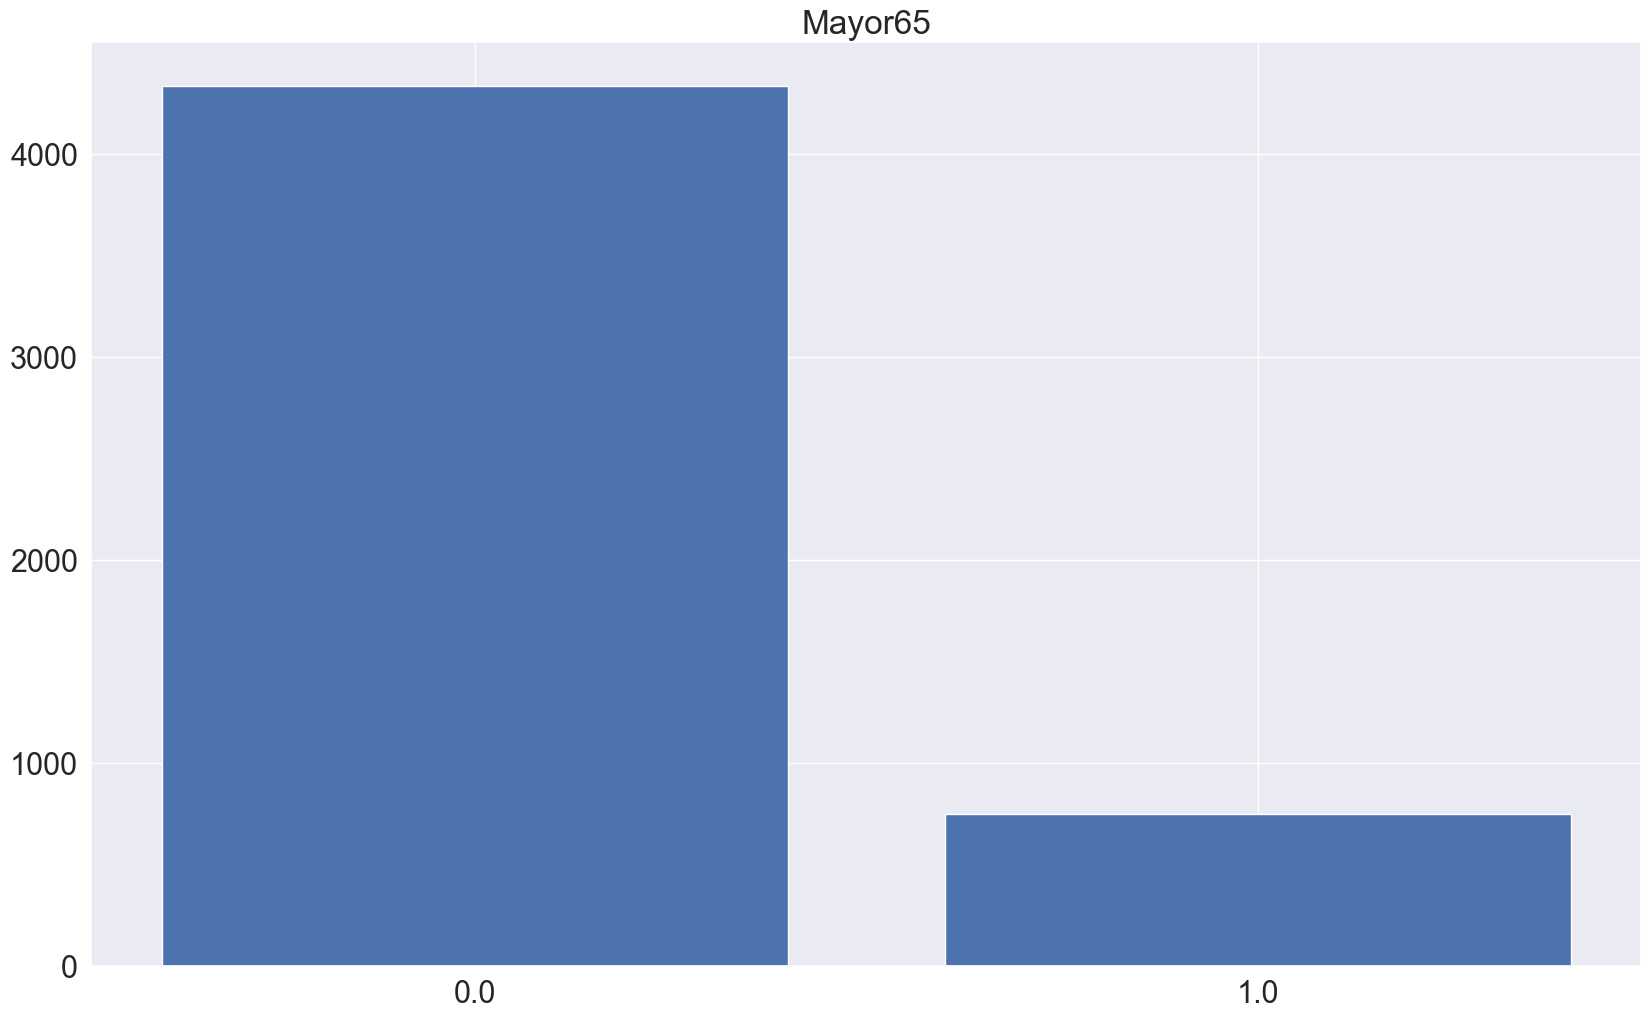

Cat


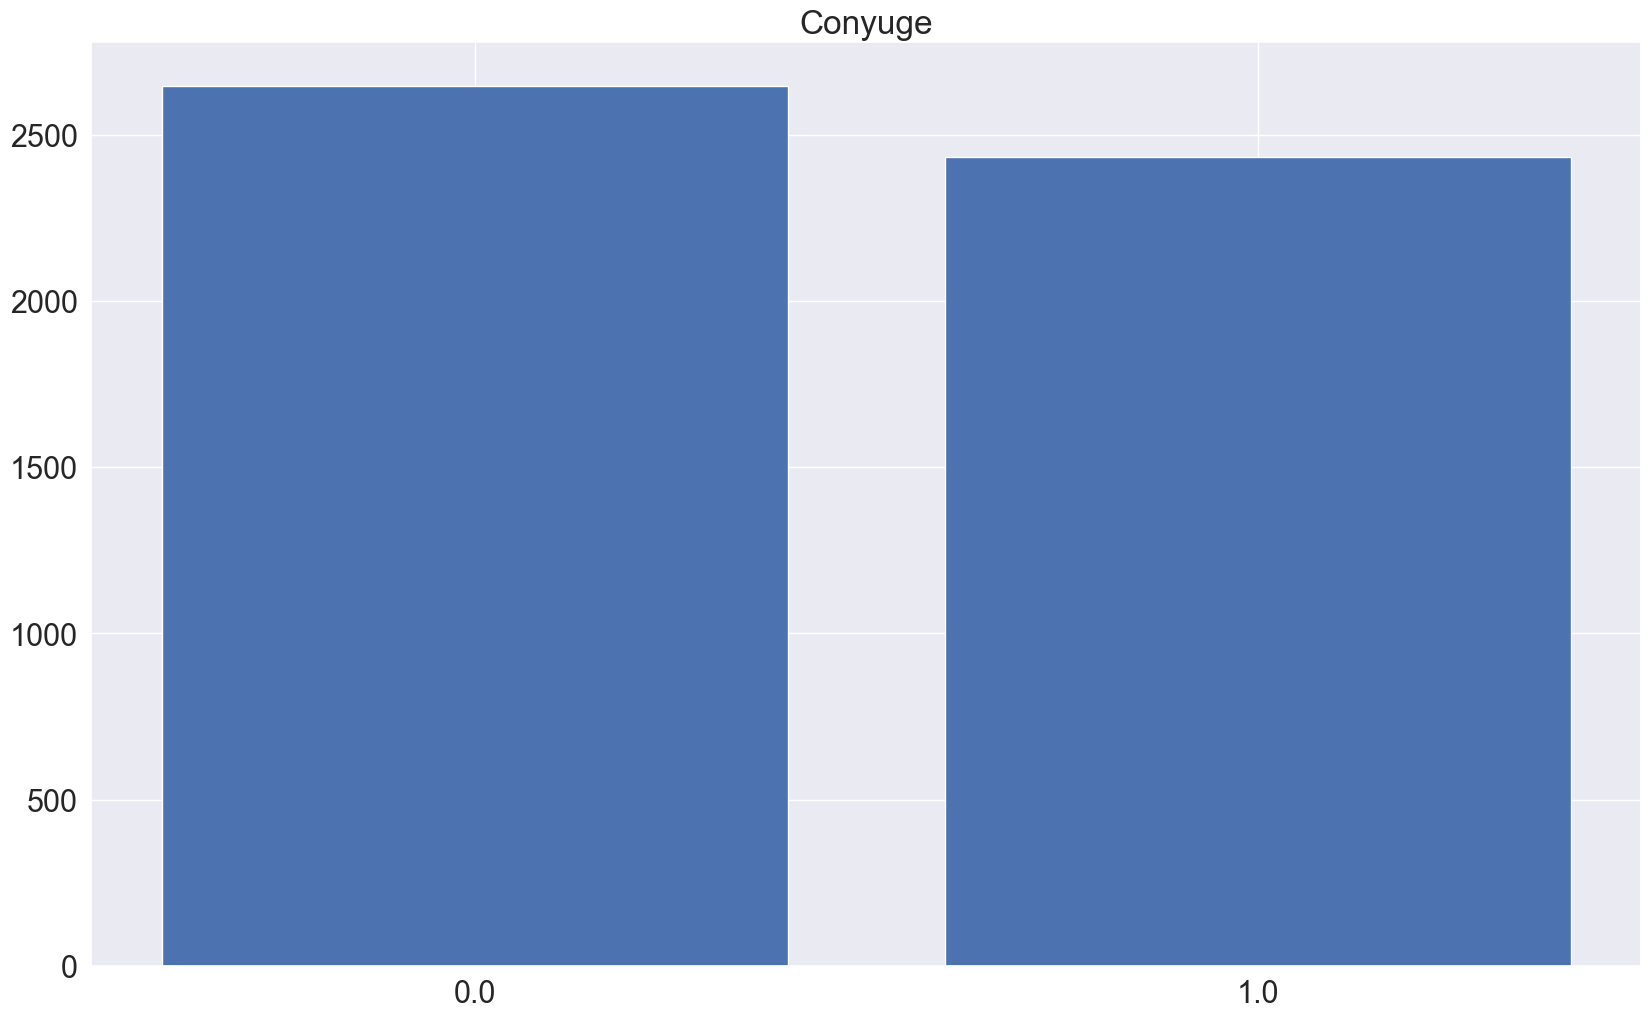

Cat


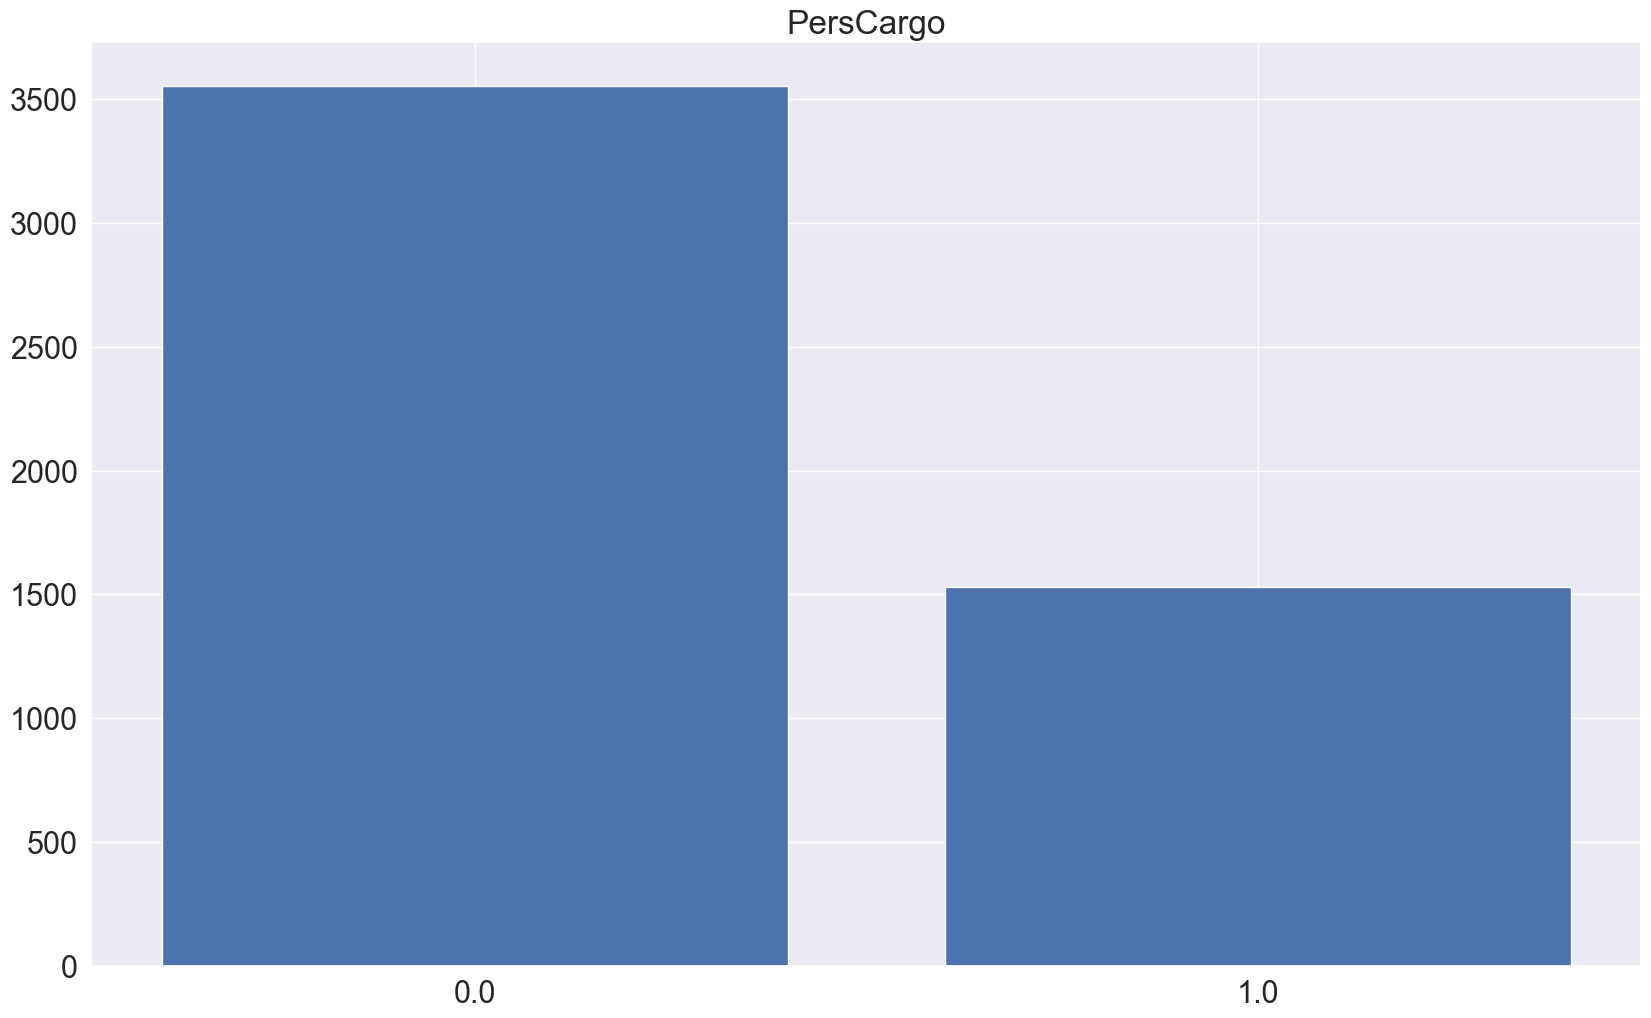

Cat


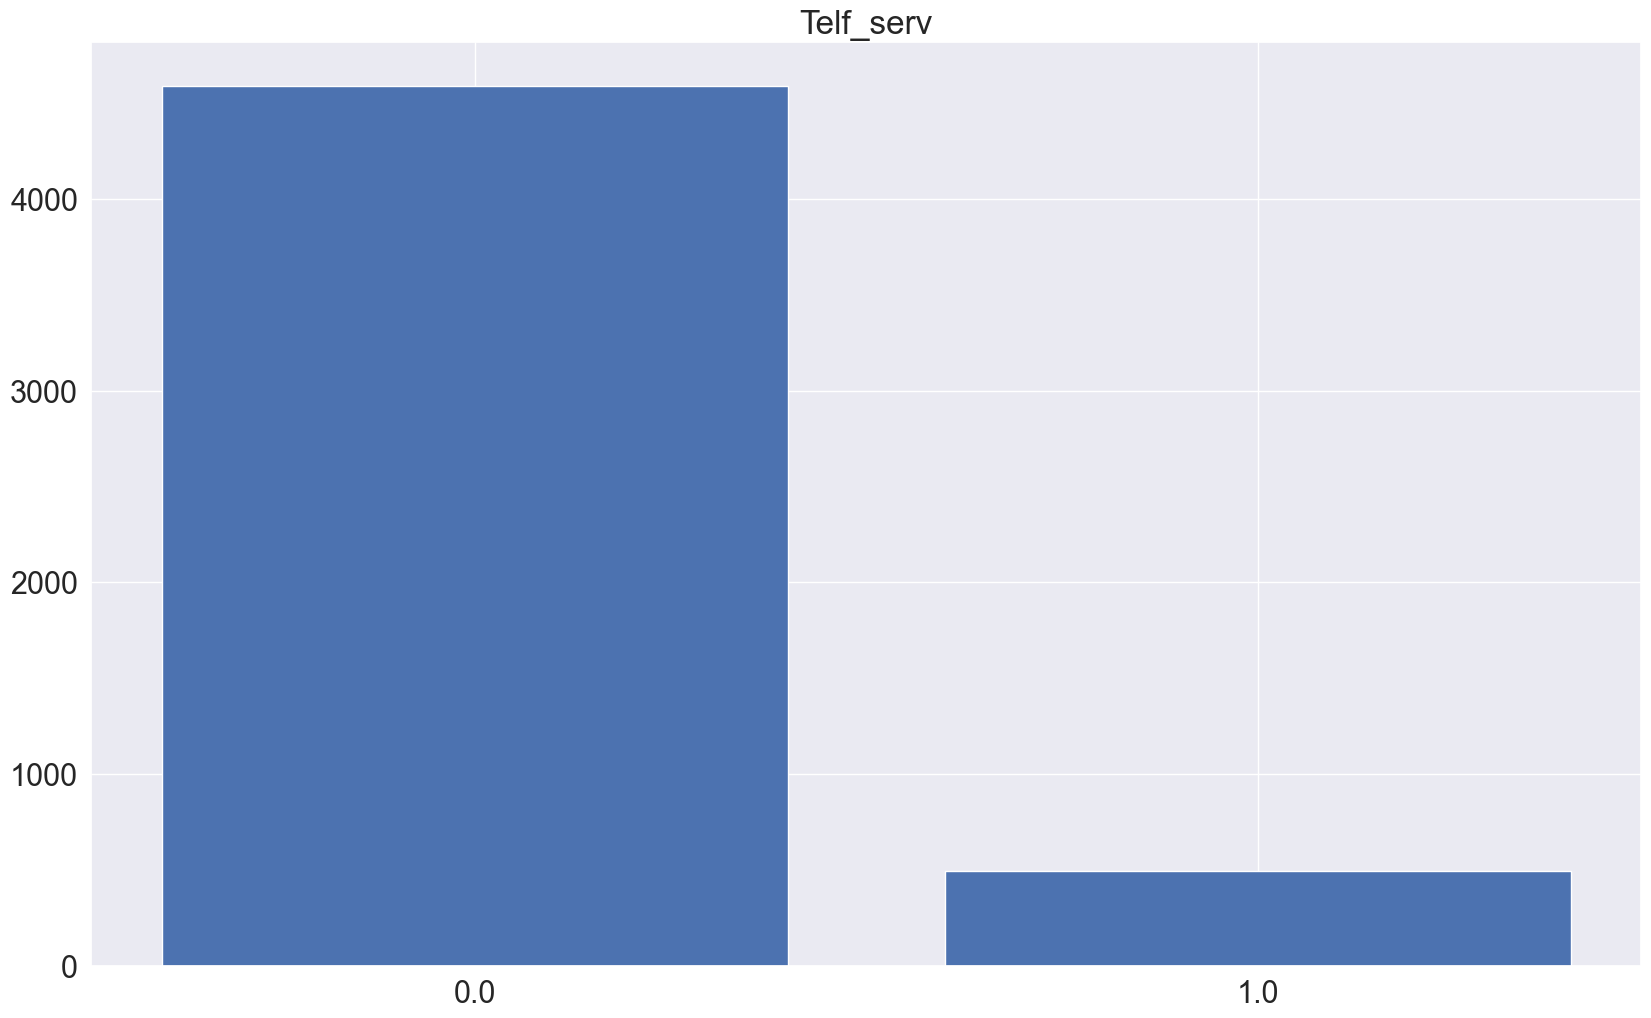

Cat


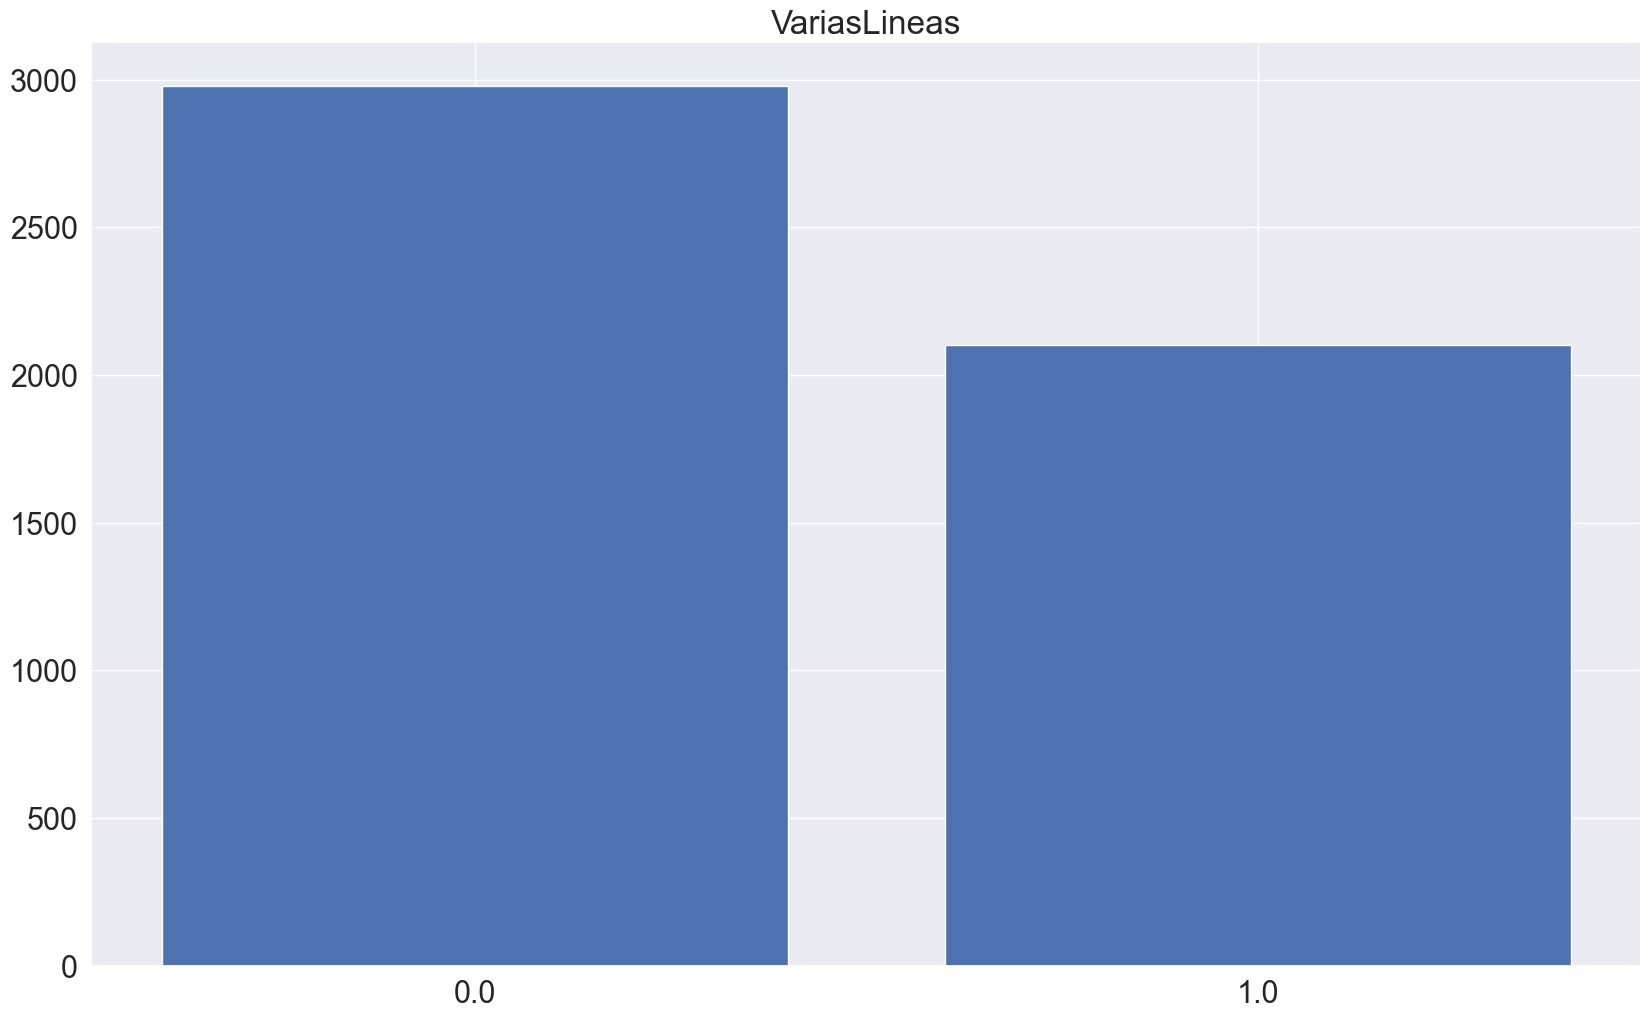

Cat


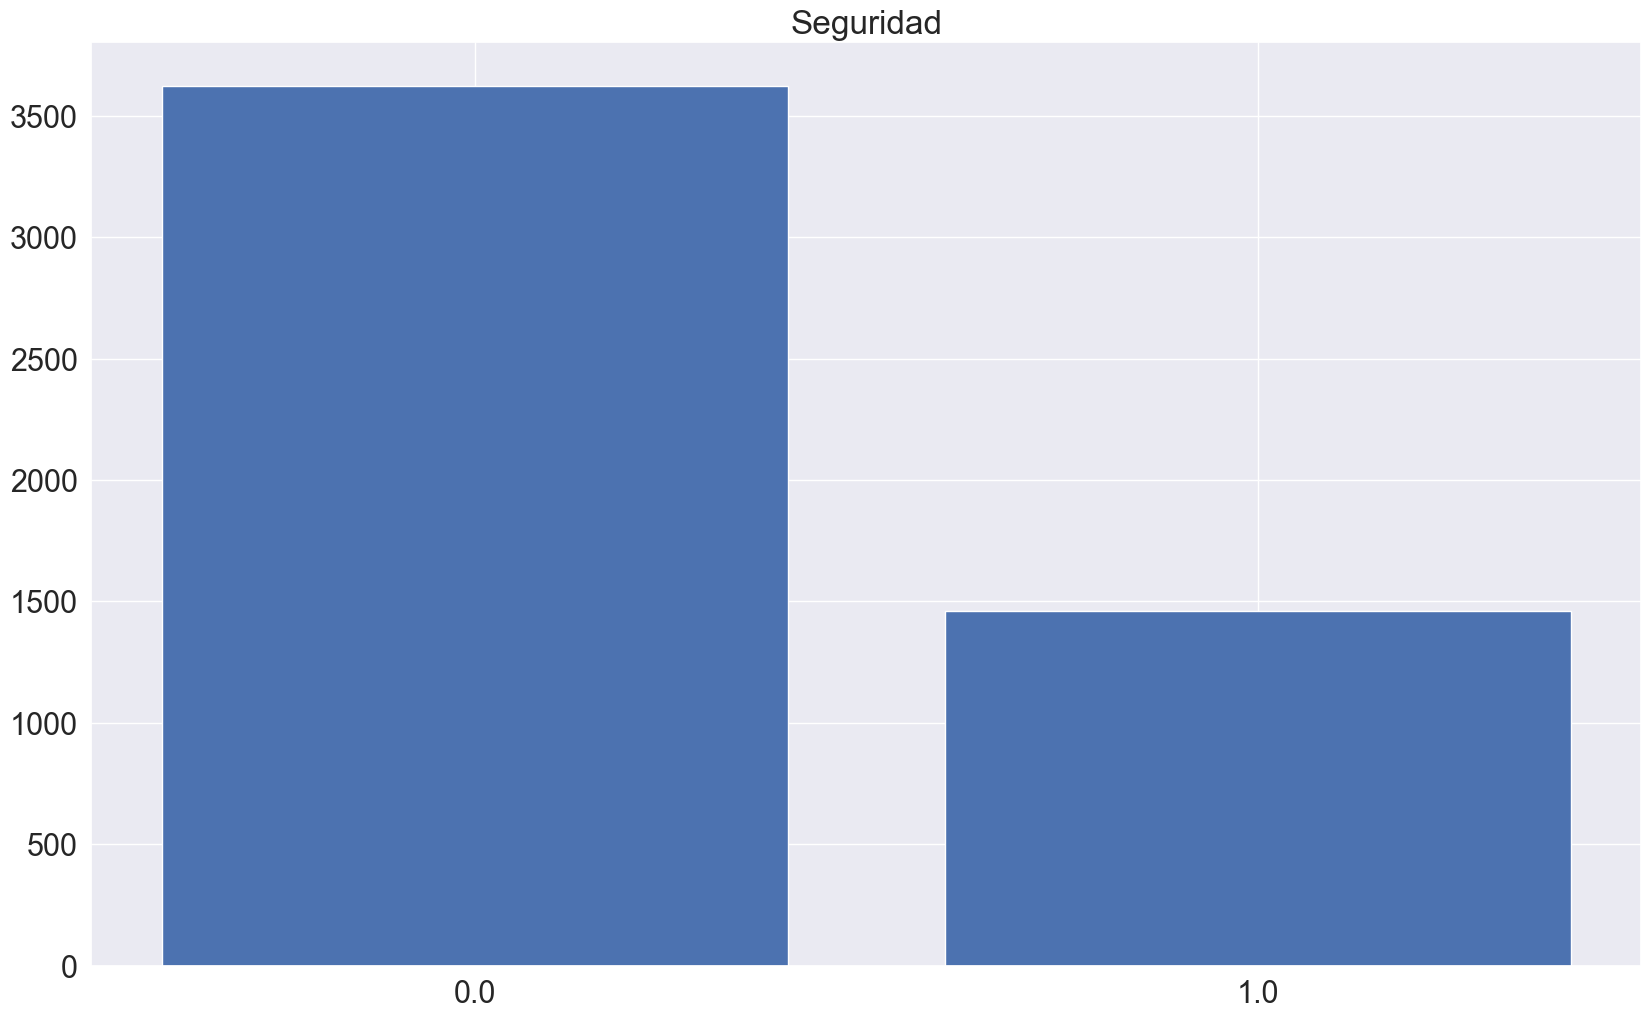

Cat


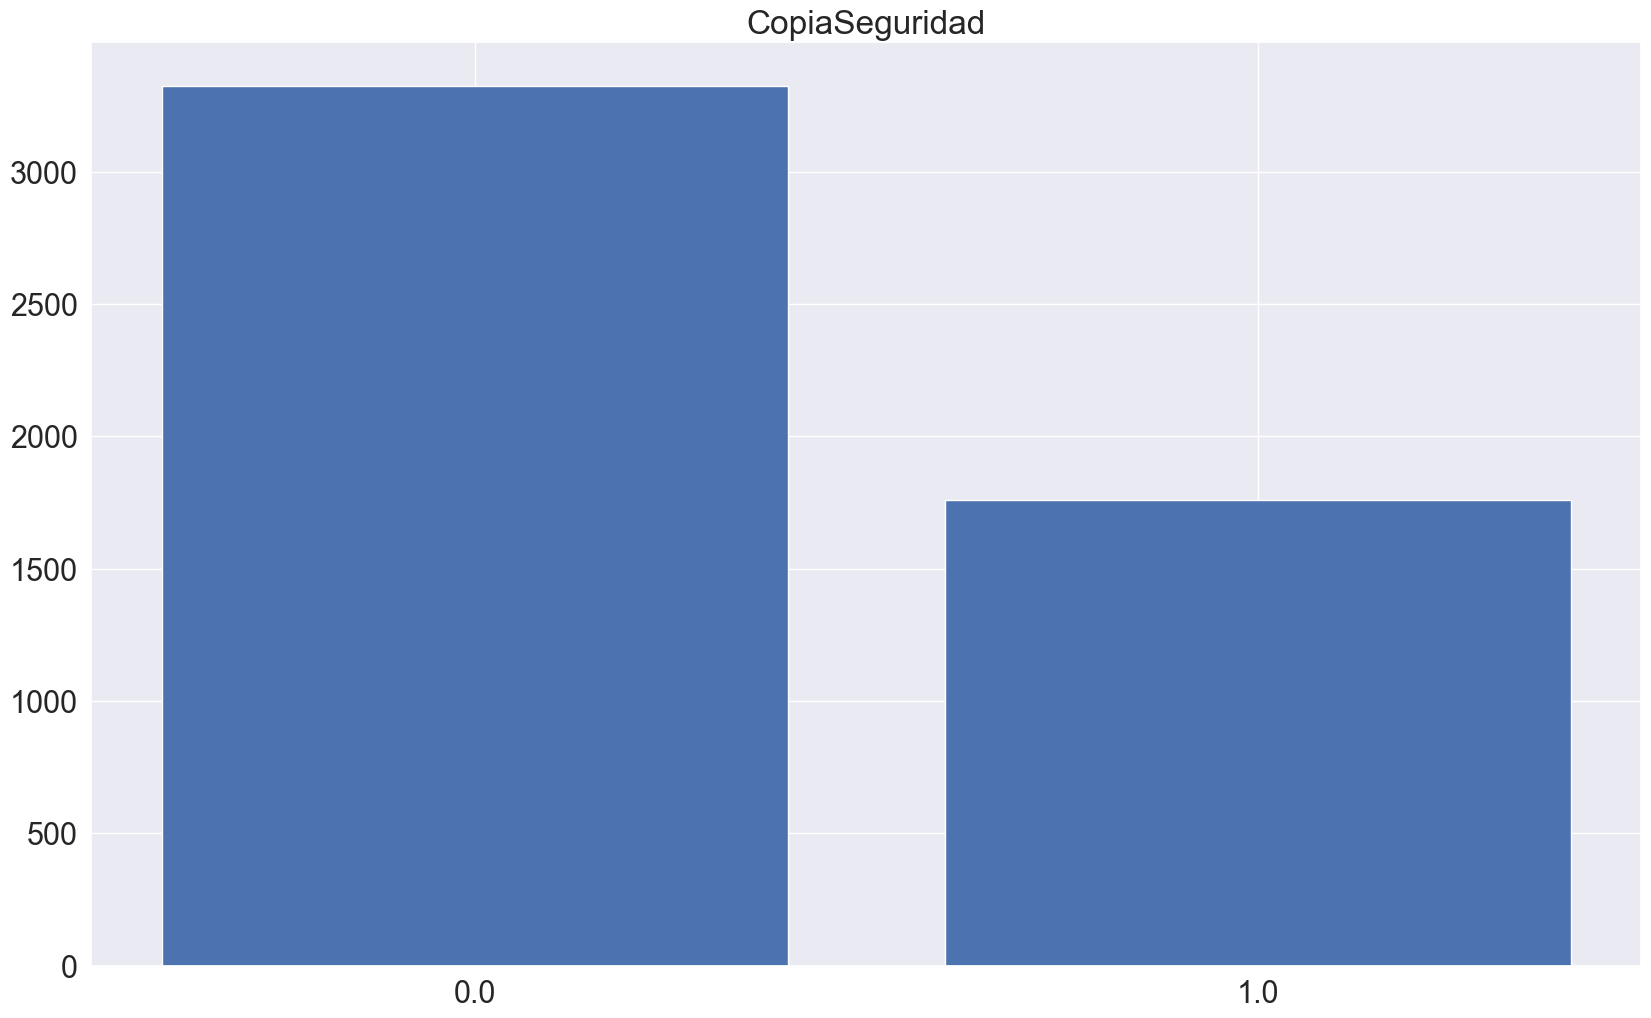

Cat


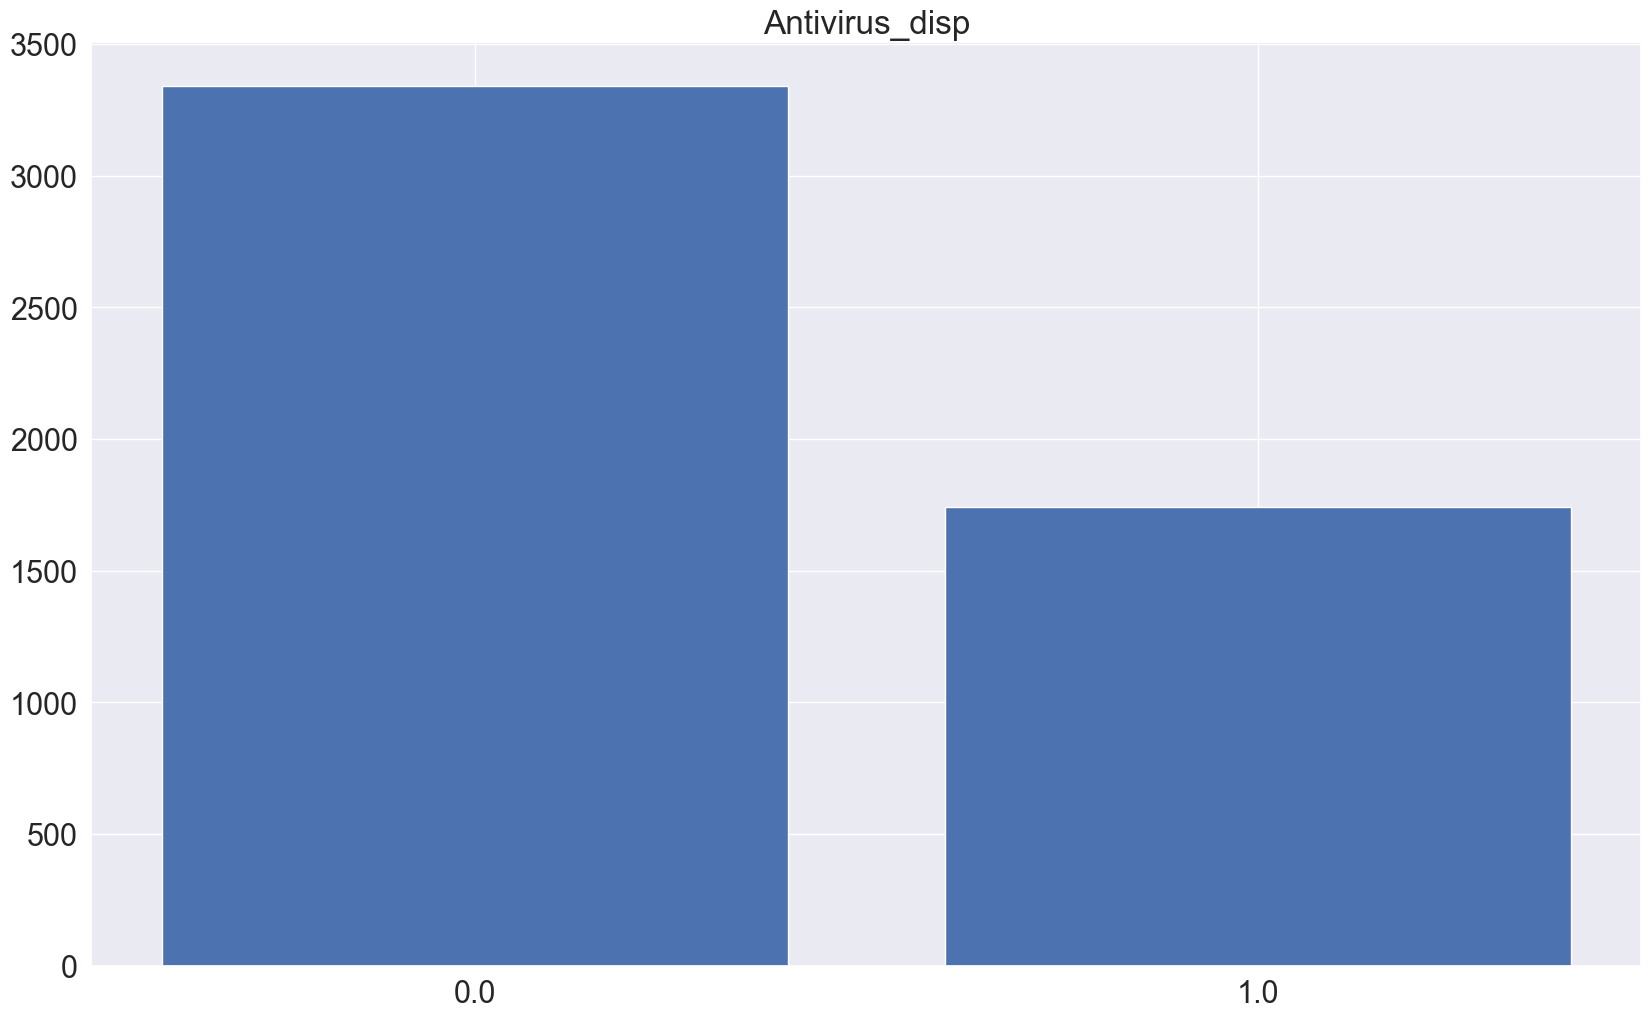

Cat


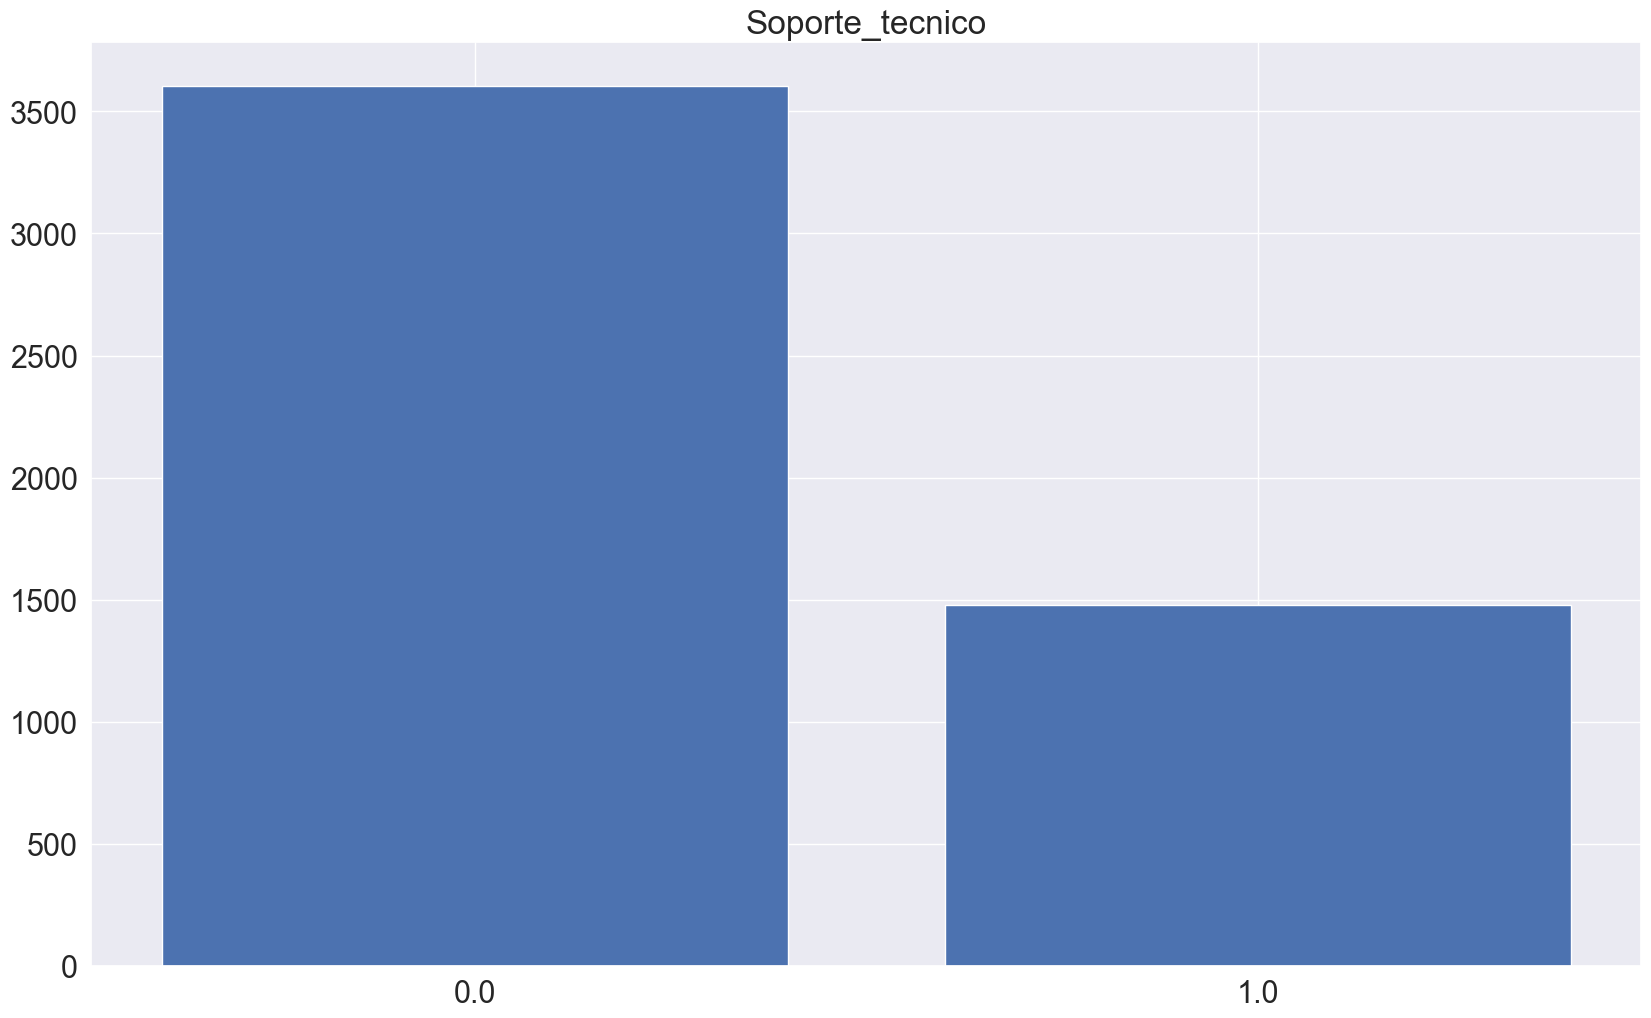

Cat


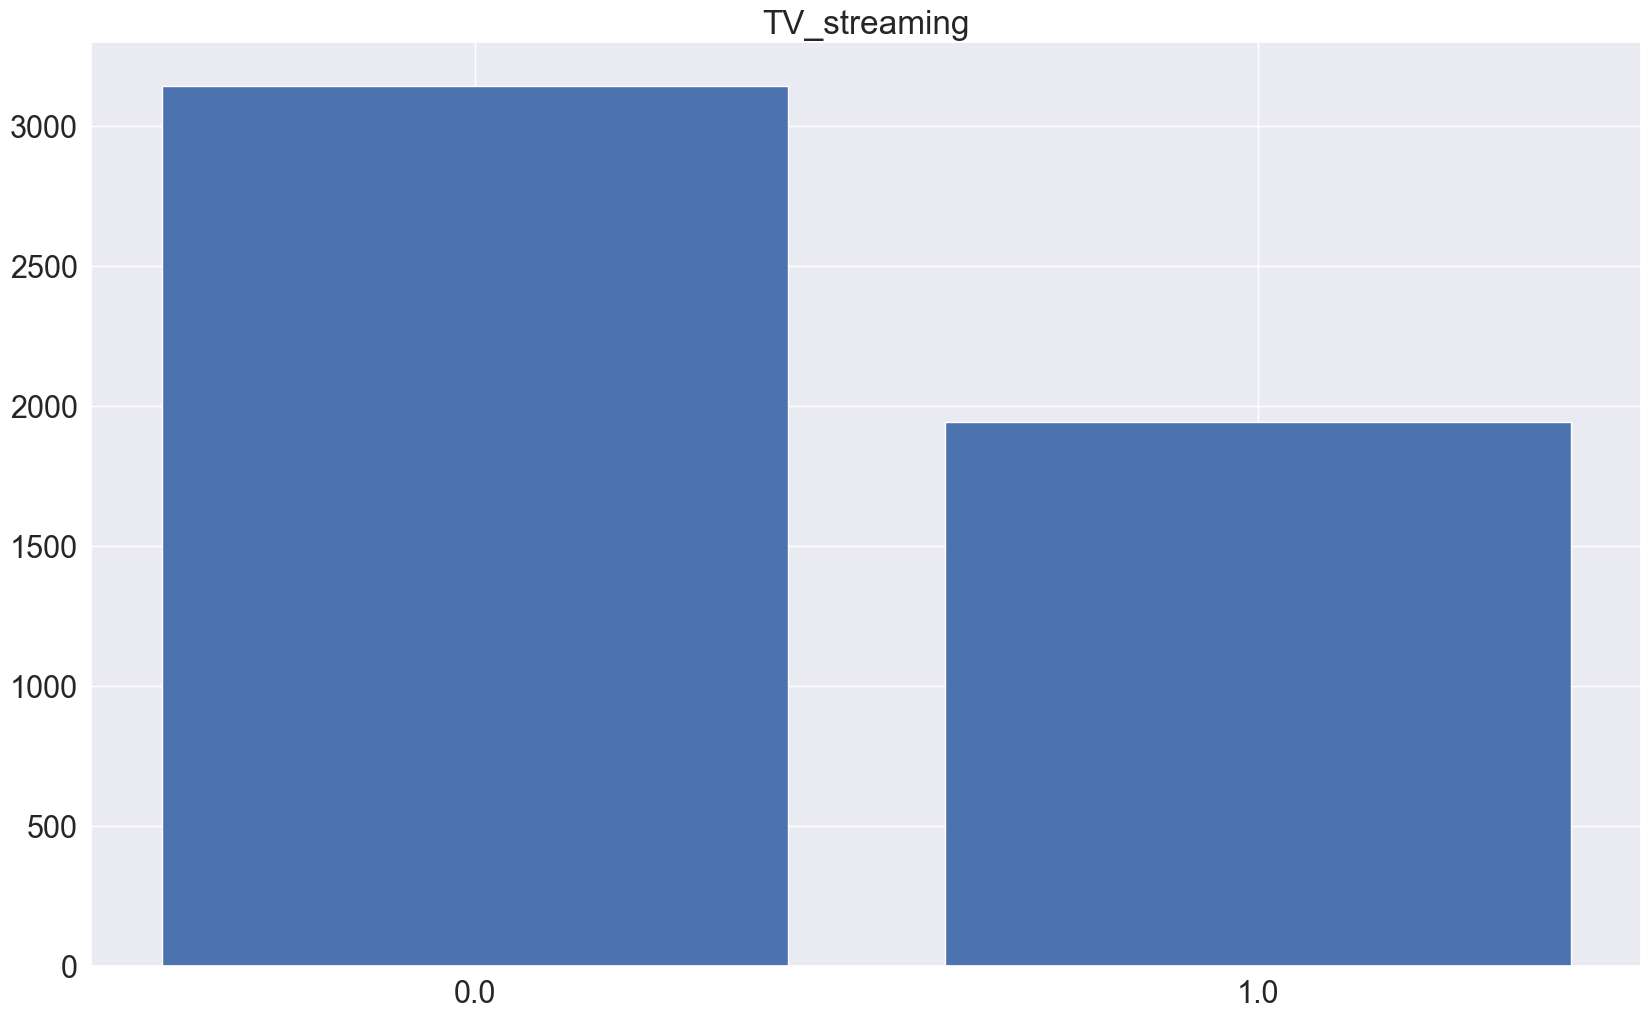

Cat


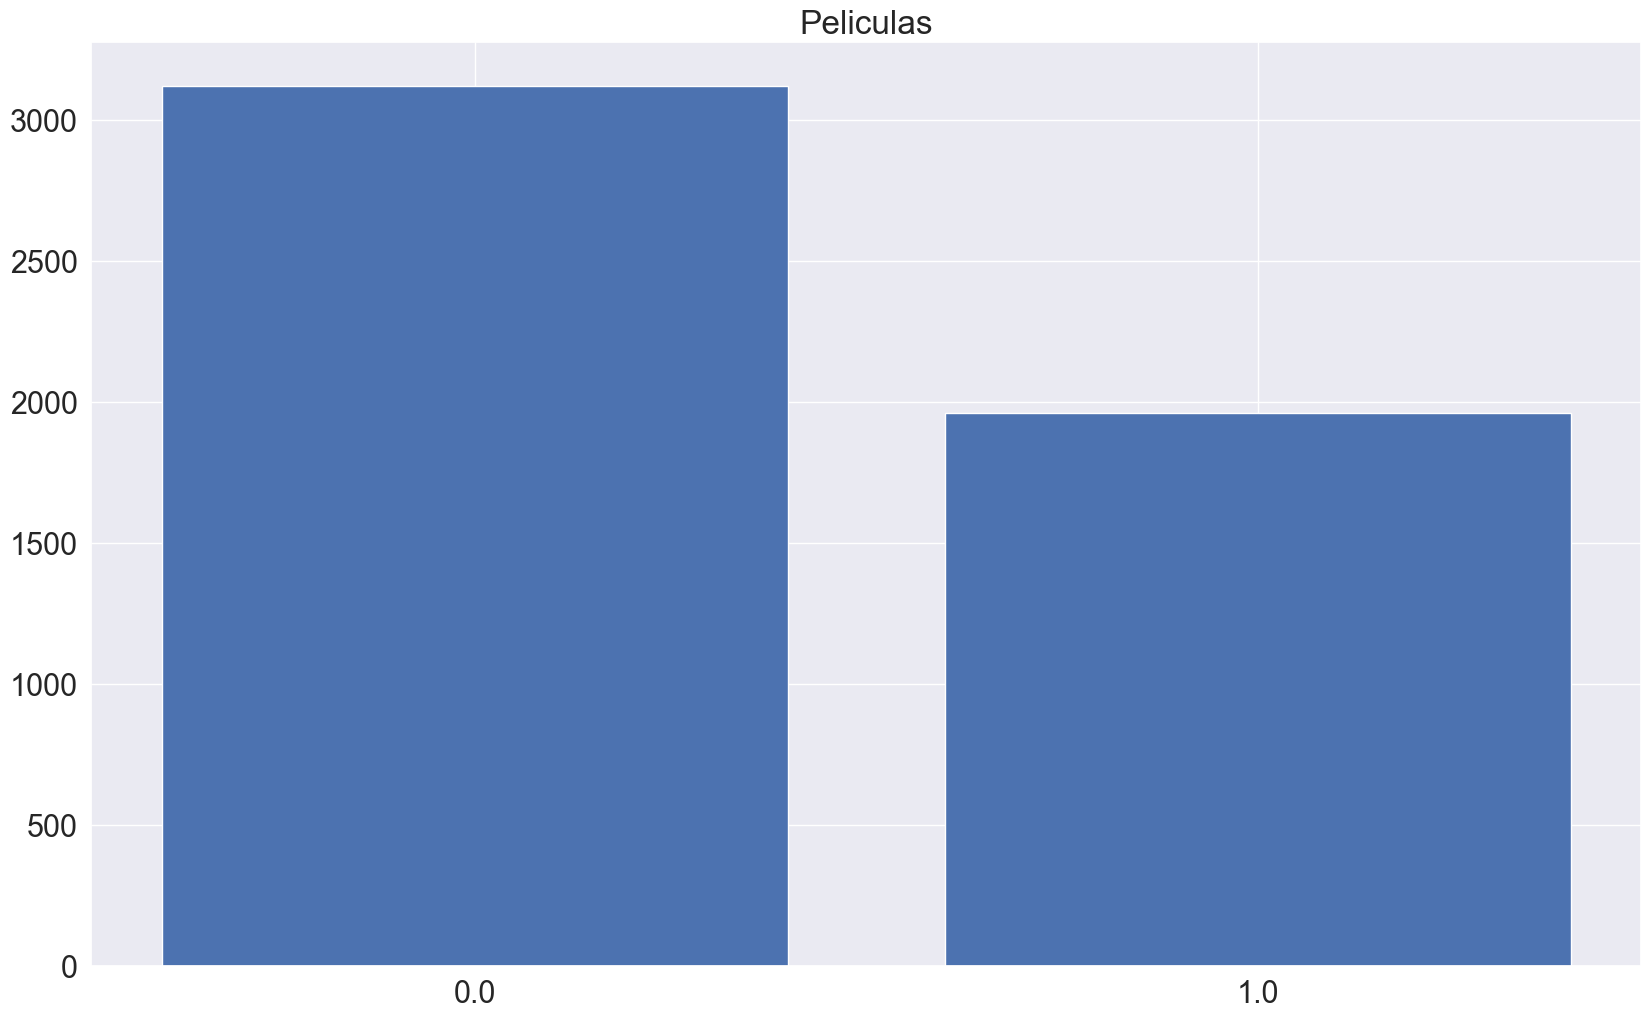

Cat


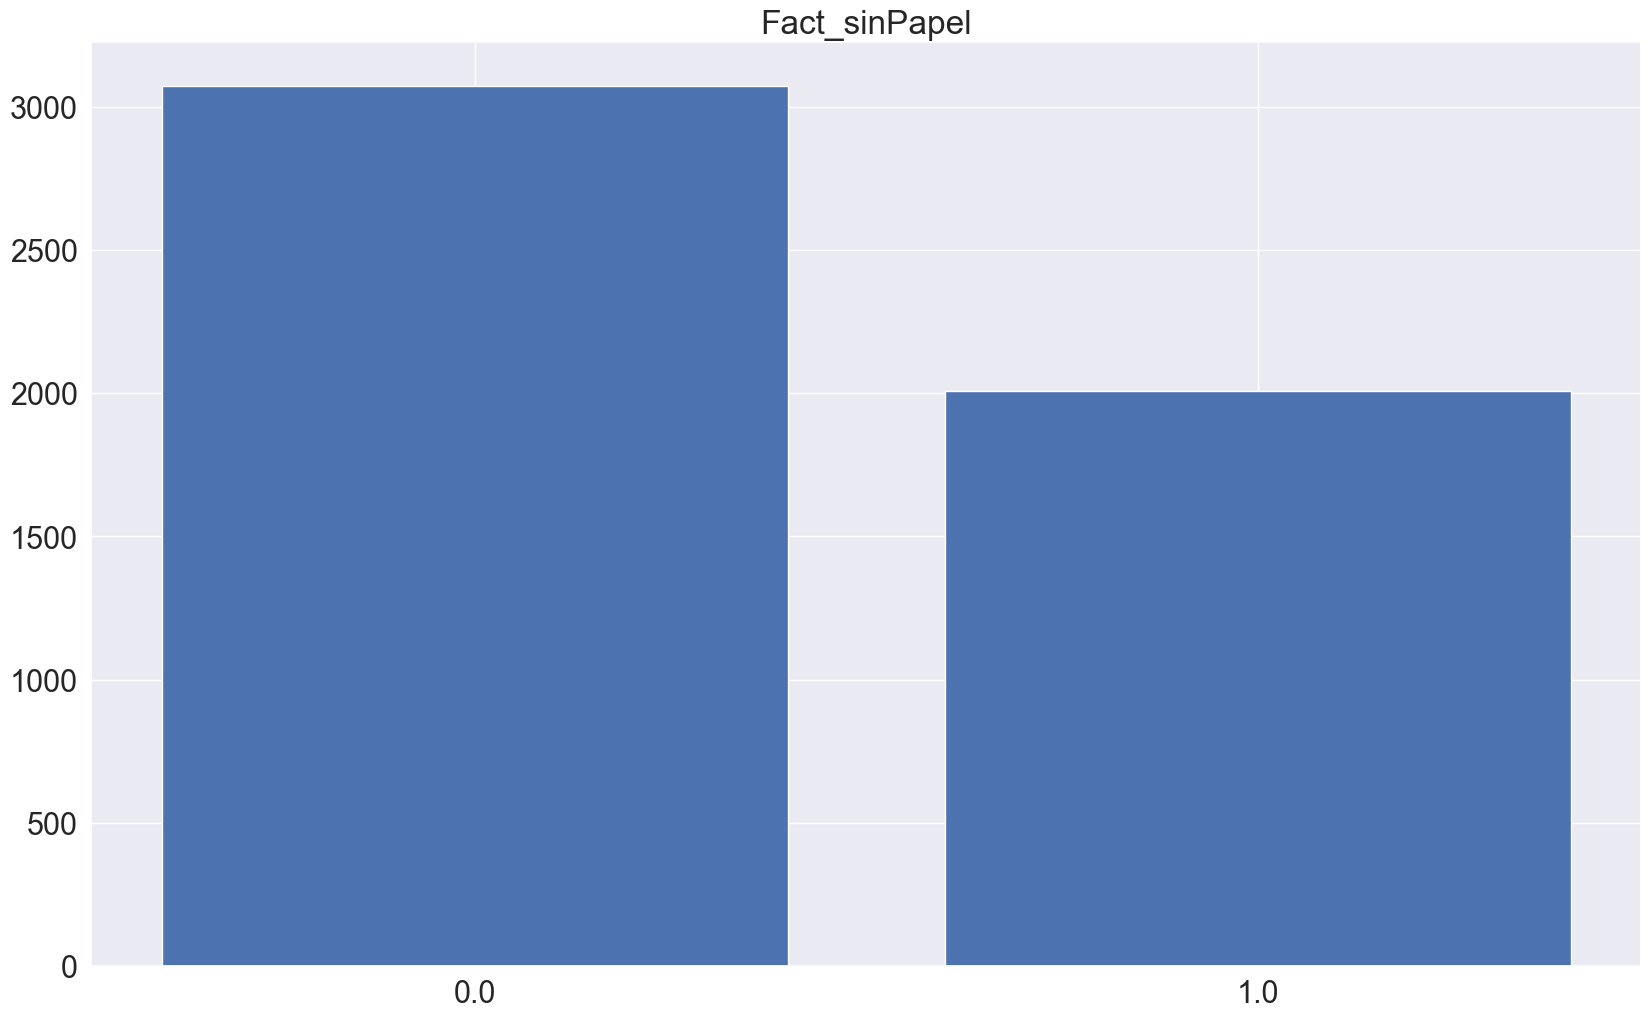

Cat


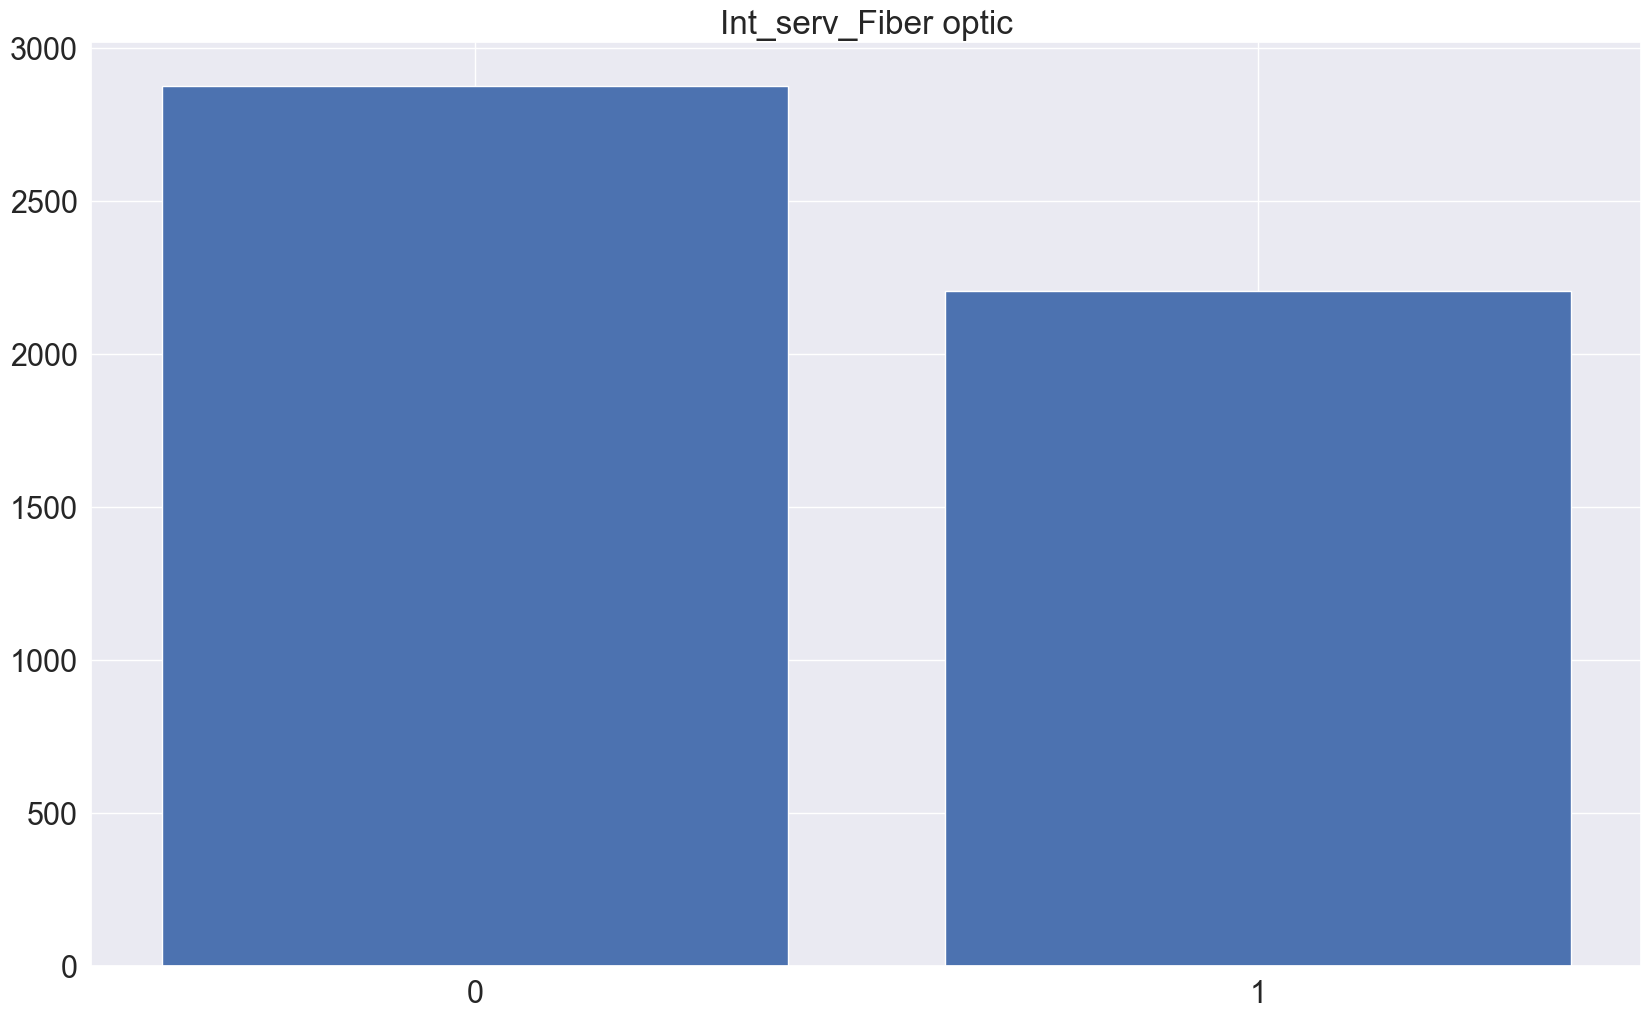

Cat


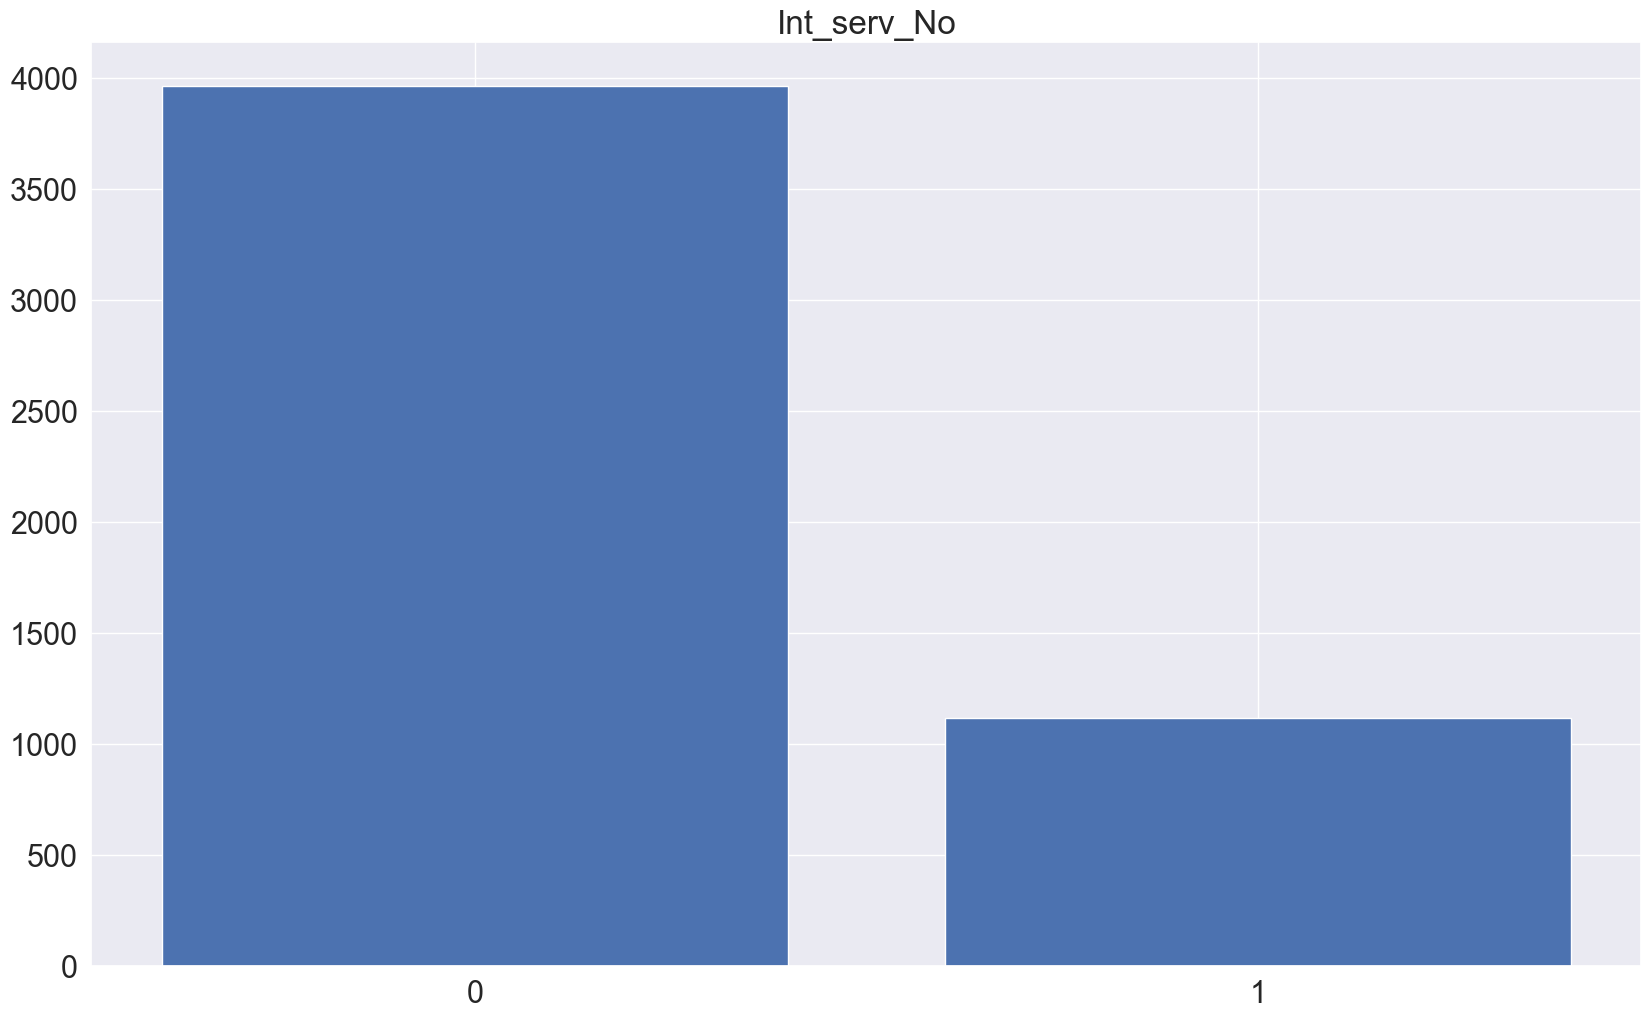

Cat


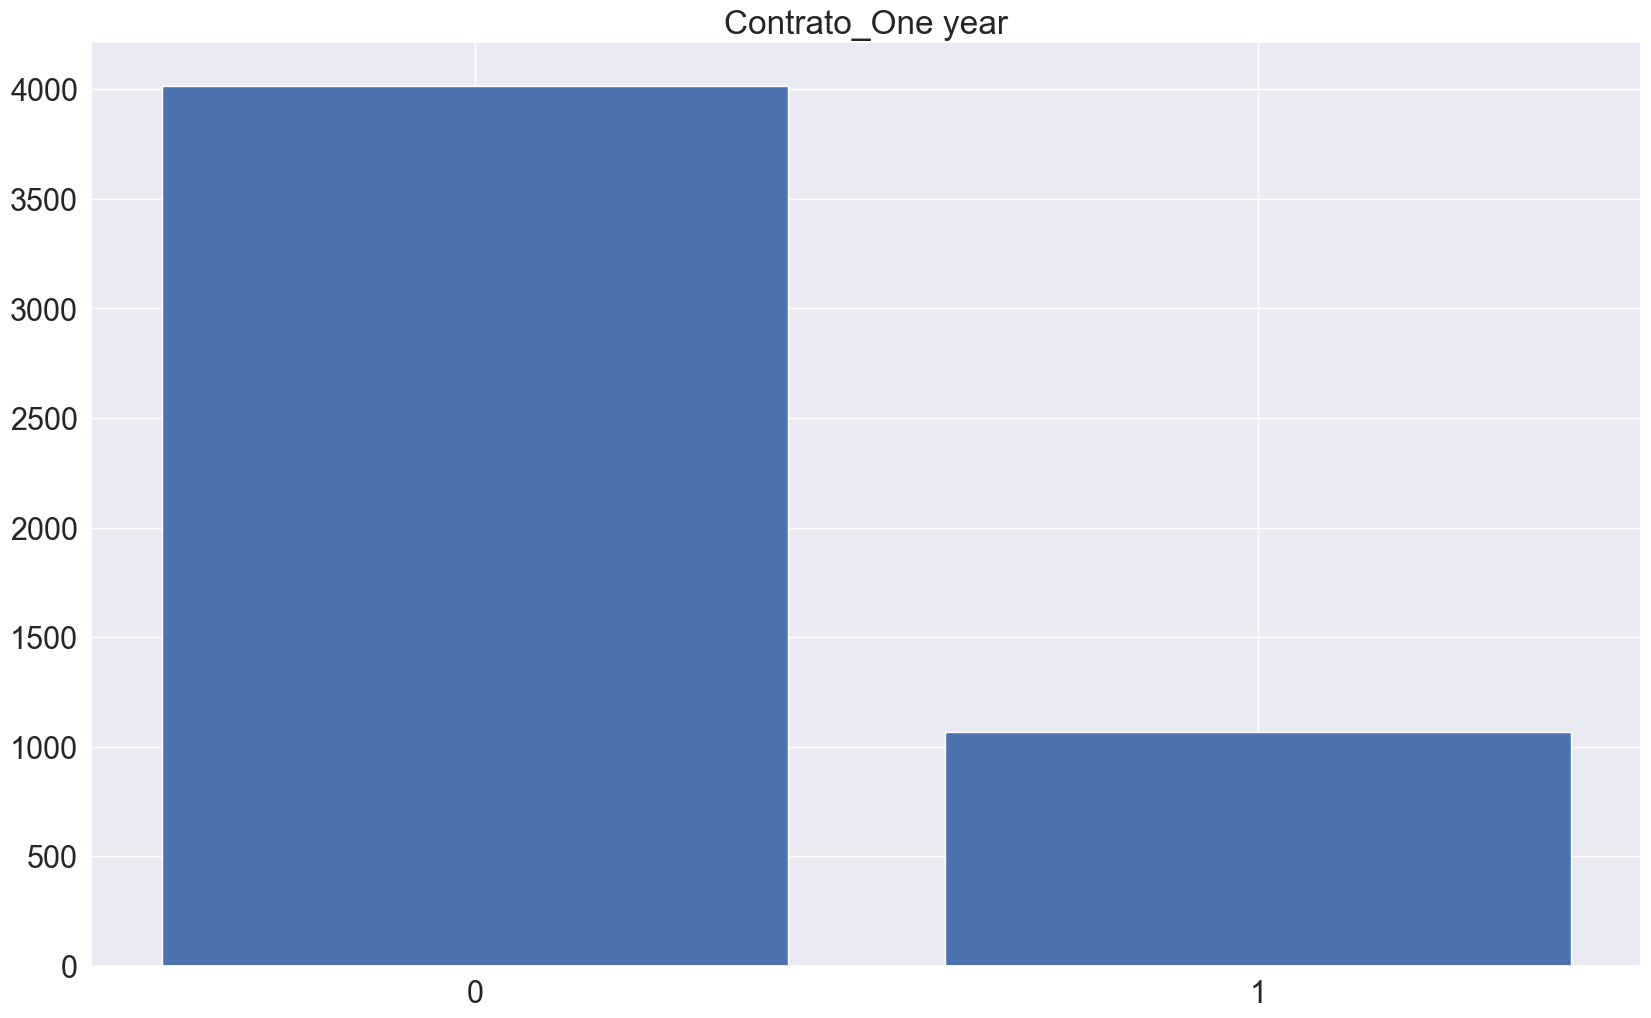

Cat


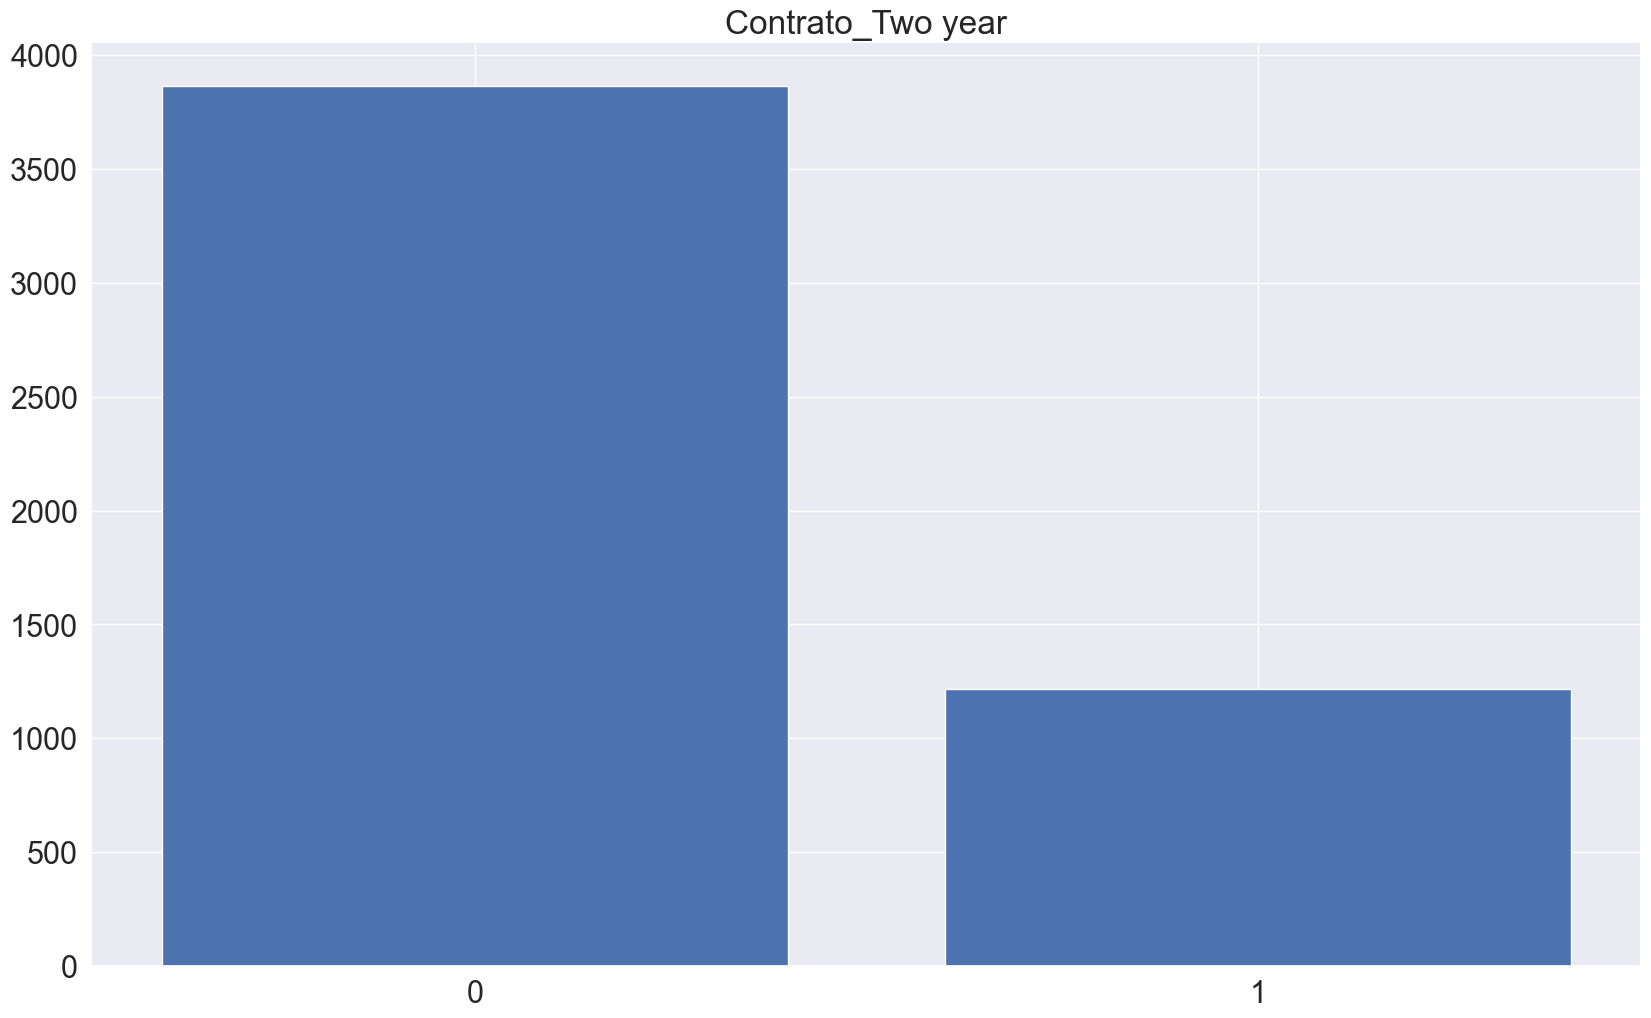

Cat


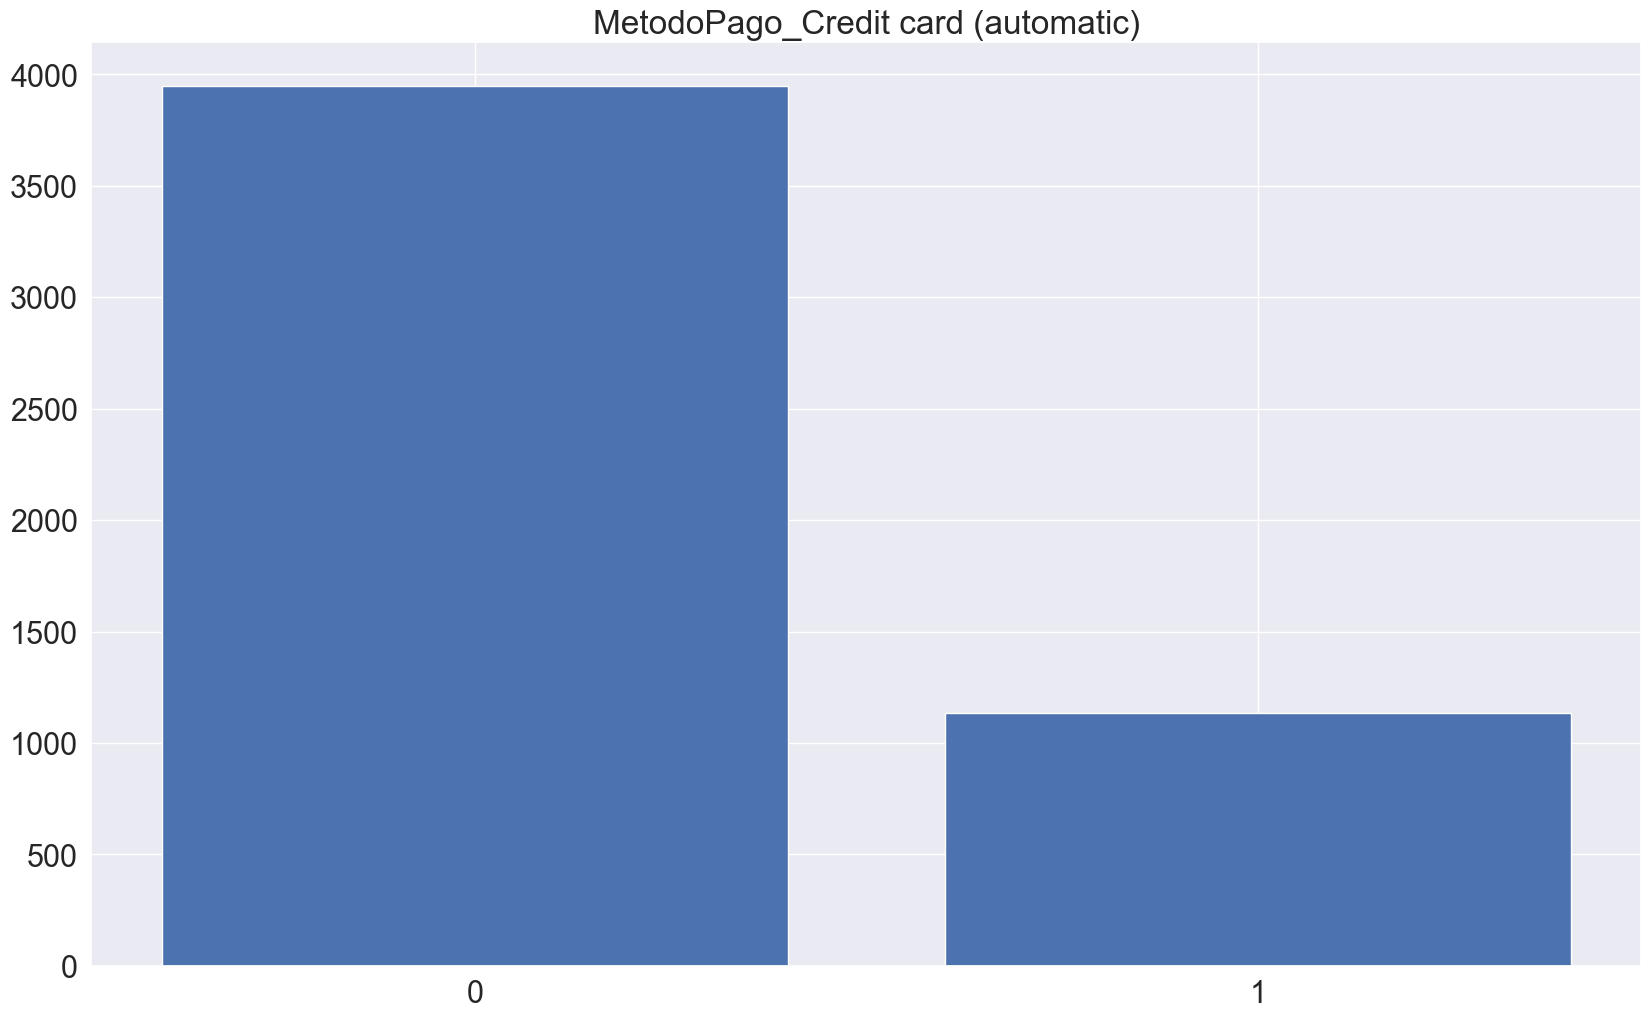

Cat


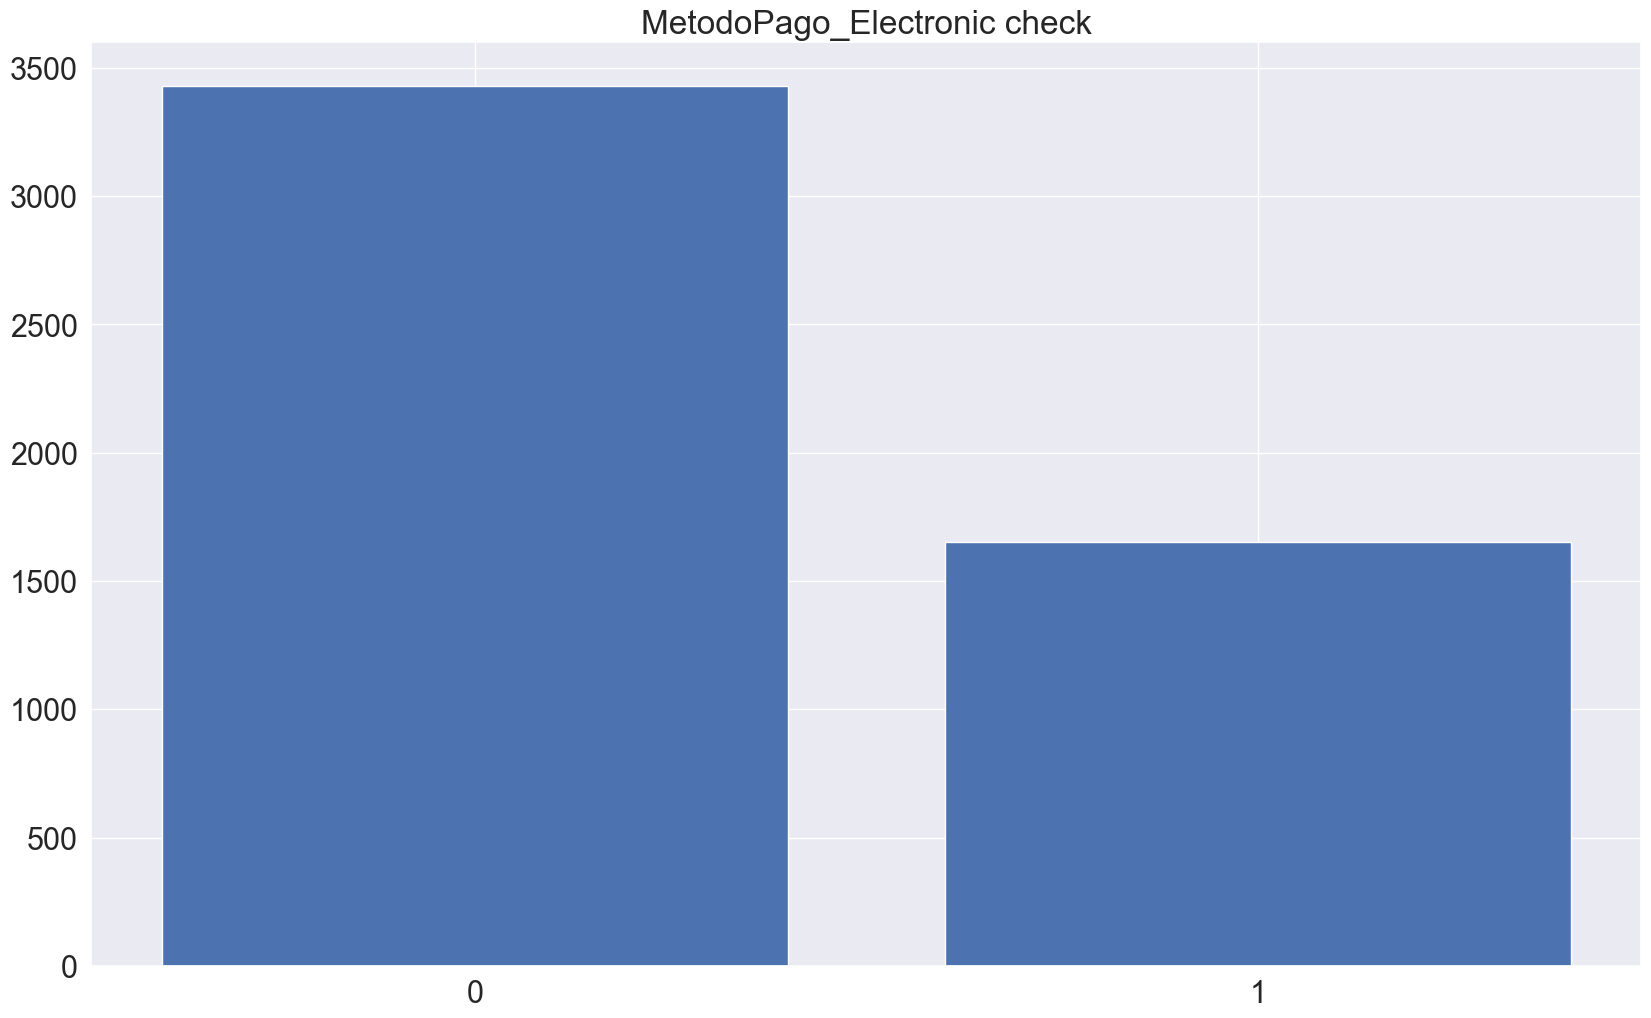

Cat


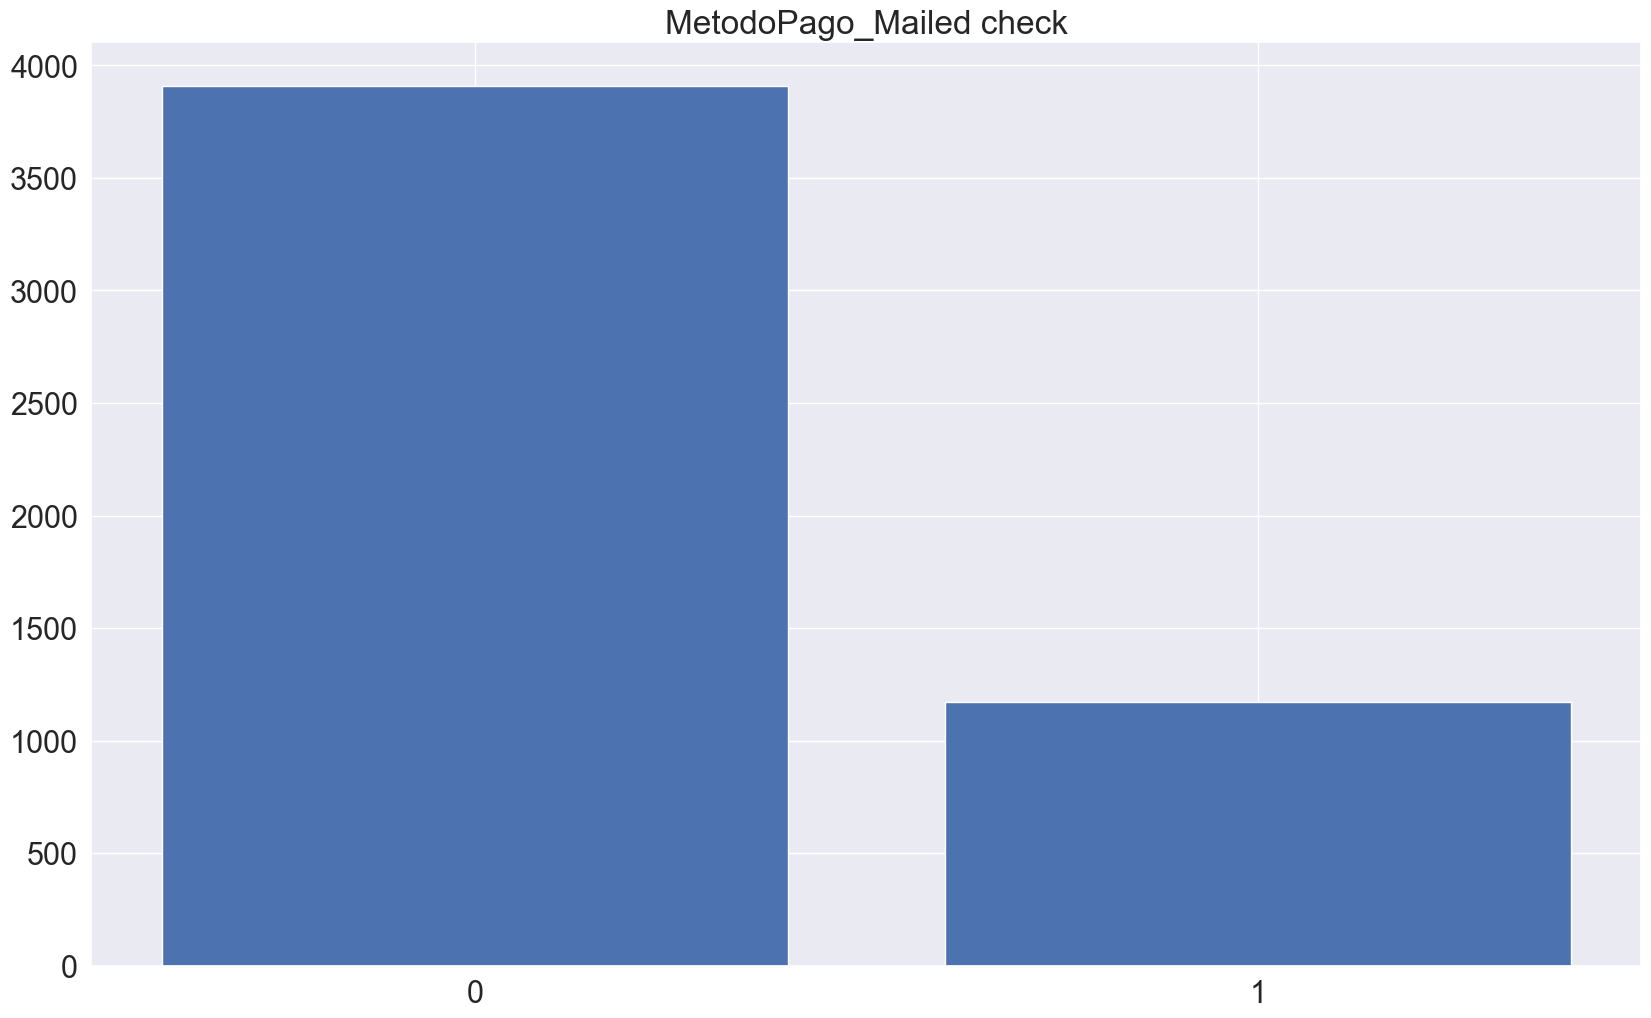

meses_antiguedad                      None
FacturaMes                            None
FacturaTotal                          None
missing_count                         None
Genero                                None
Mayor65                               None
Conyuge                               None
PersCargo                             None
Telf_serv                             None
VariasLineas                          None
Seguridad                             None
CopiaSeguridad                        None
Antivirus_disp                        None
Soporte_tecnico                       None
TV_streaming                          None
Peliculas                             None
Fact_sinPapel                         None
Int_serv_Fiber optic                  None
Int_serv_No                           None
Contrato_One year                     None
Contrato_Two year                     None
MetodoPago_Credit card (automatic)    None
MetodoPago_Electronic check           None
MetodoPago_

In [89]:
df_fuga_train.apply(lambda x: NuestrasFunciones.plot(x))
#Pocos mayores de 65
#poca fuga--usar stratified split
#Meses de antiguedad con extremos cargadas
#telf serv pocos 0
#Continuas no tienen distribución normal, puede que log ayude.

In [90]:
df_fuga_train.select_dtypes(include = np.number).apply(lambda x: NuestrasFunciones.gestiona_outliers(x))

meses_antiguedad
FacturaMes
FacturaTotal


,meses_antiguedad,FacturaMes,FacturaTotal
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0


### Ya sabíamos que hubiese sido complicado encontrar outliers por el escalado de datos y por los box plots anteriores, pero mejor revisar que todo esté bien

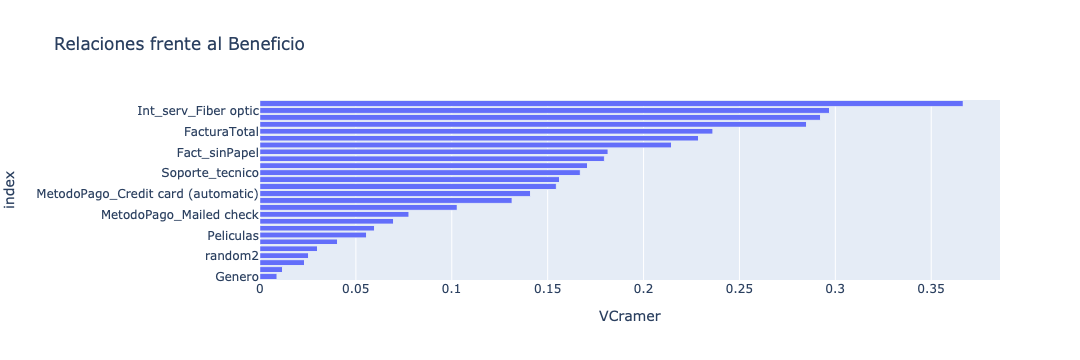

In [91]:
df_fuga_train["random"] = np.random.uniform(0,1, size=df_fuga_train.shape[0])
df_fuga_train["random2"] = np.random.uniform(0,1, size=df_fuga_train.shape[0])
tablaCramer = pd.DataFrame(df_fuga_train.apply(lambda x: NuestrasFunciones.cramers_v(x,Y_train)),columns=['VCramer'])

px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente al Beneficio').update_yaxes(categoryorder="total ascending")

Las variables de ruido tienen muy baja asociación con la variable objetivo, tal como la variable missing_count que mide los NAs por fila. Buena señal para nosotros.

Podemos observar además las variables que más y menos se asocian con la objetivo

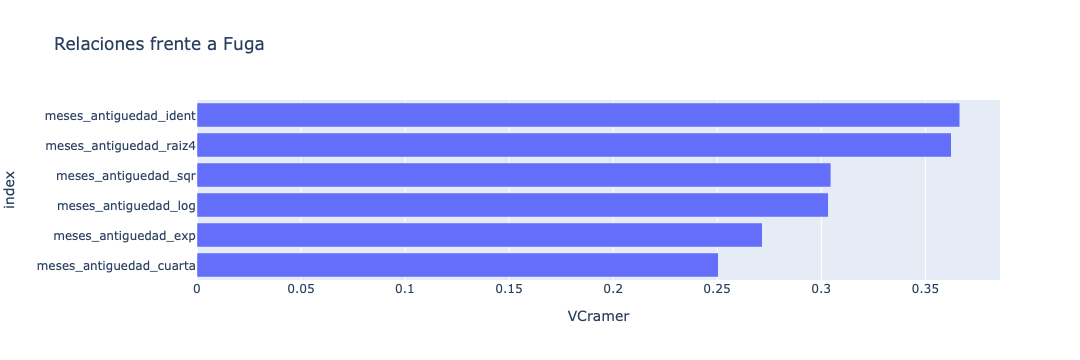

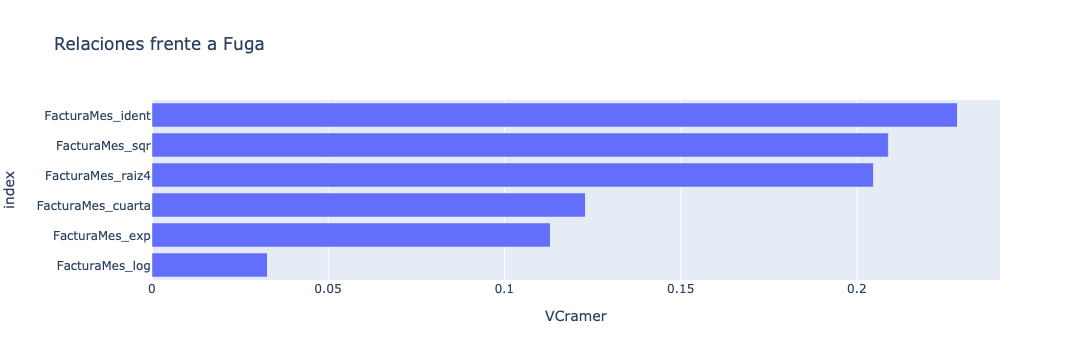

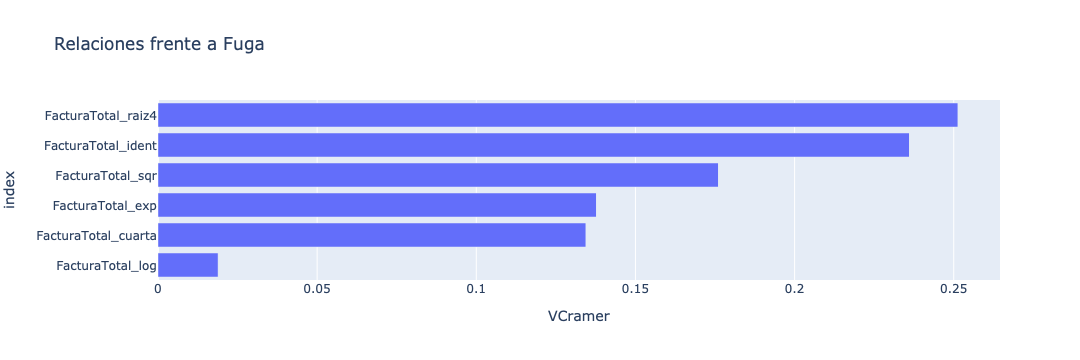

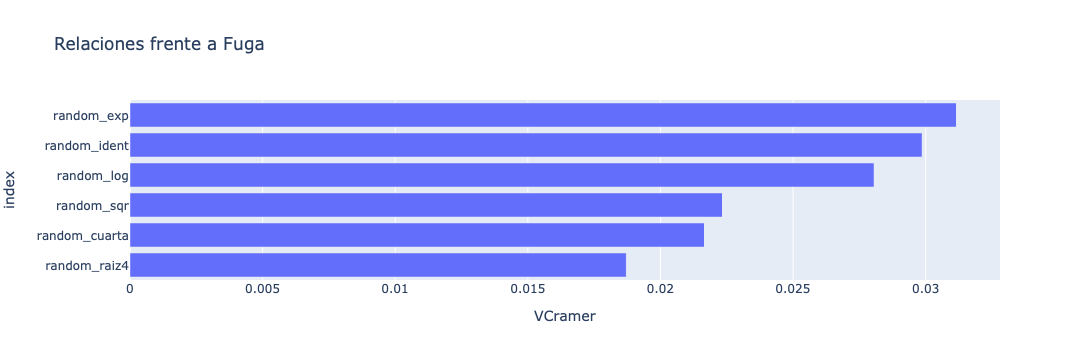

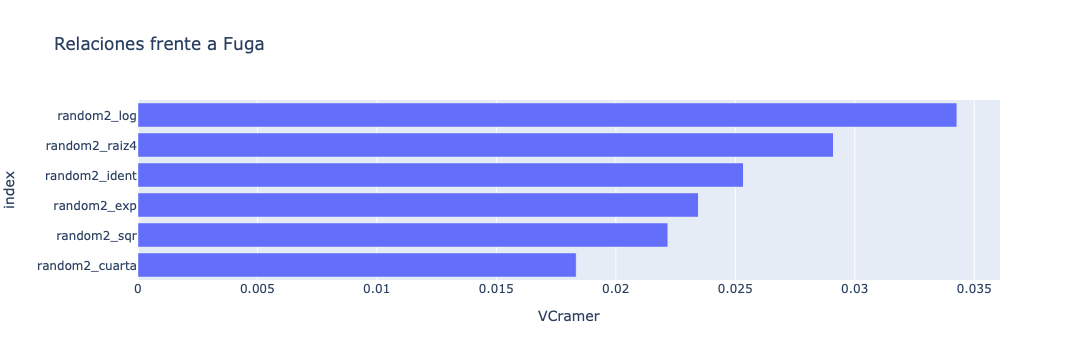

In [92]:
df_transformaciones_nombre = df_fuga_train.select_dtypes(include = np.number).apply(lambda x: NuestrasFunciones.mejorTransf(x,Y_train, tipo='cramer', name = True, graf = True))


### La variable sin transformar siempre es la variable de mayor asociación a la objetivo, obviamente no nos importa que en las random mejore

<Axes: >

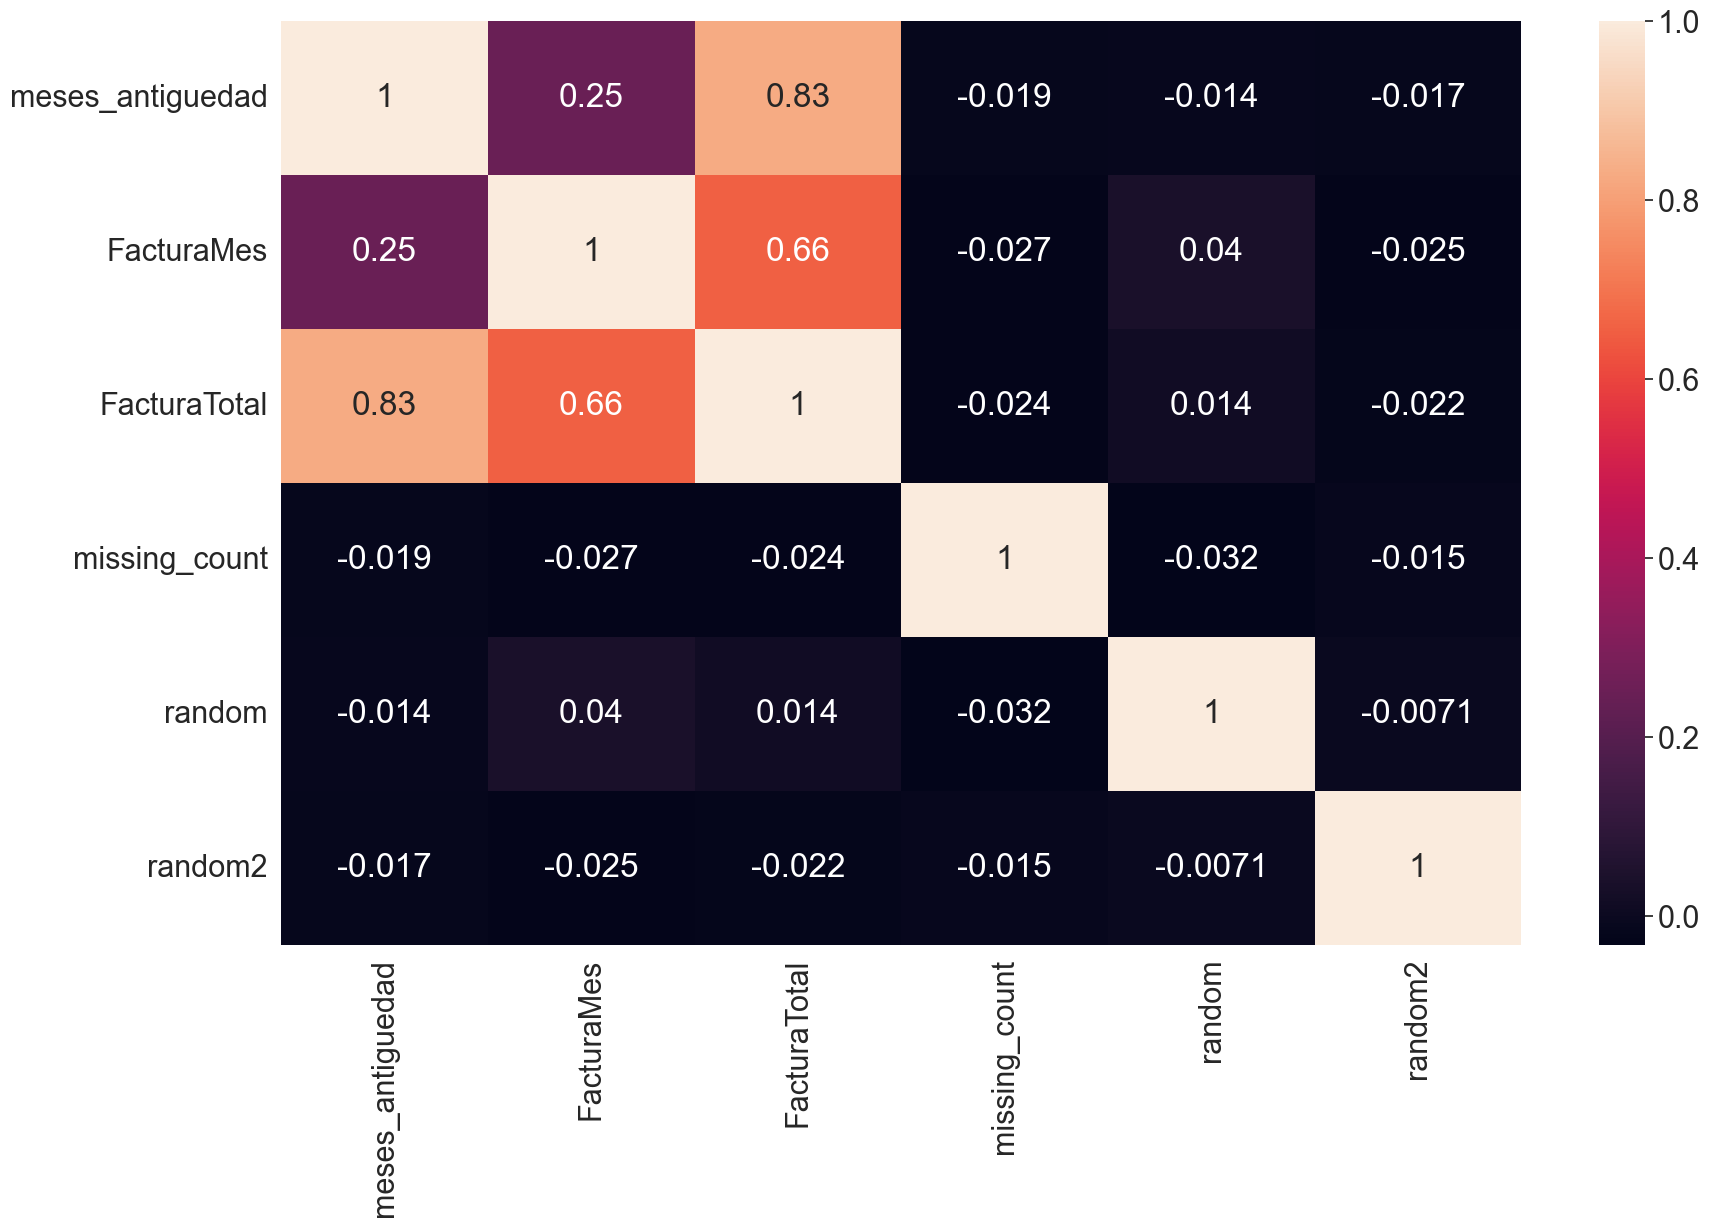

In [93]:
df_fuga_train.missing_count = df_fuga_train.missing_count.astype("int")
corr = df_fuga_train.select_dtypes(include=np.number).corr()
#corr.style.background_gradient(cmap='coolwarm').format(precision=3)
sns.heatmap(corr, annot=True)

### Debido a la fuerte correlación que presenta Factura total con factura mes y con meses antigüedad y al hecho de que FacturaTotal puede ser obviamente considerado una combinación lineal de ambas, eliminaré la variable Factura total. Evitando así problemas de multicolinearidad. Además la información que esta variable le pudo dar al modelo será otorgada por las variables anteriormente mencionadas.

### Debido al posterior uso de feature selector y pca decido comentar el drop de la variable

In [94]:
#df_fuga_train.drop("FacturaTotal", axis = 1, inplace = True)

<Axes: >

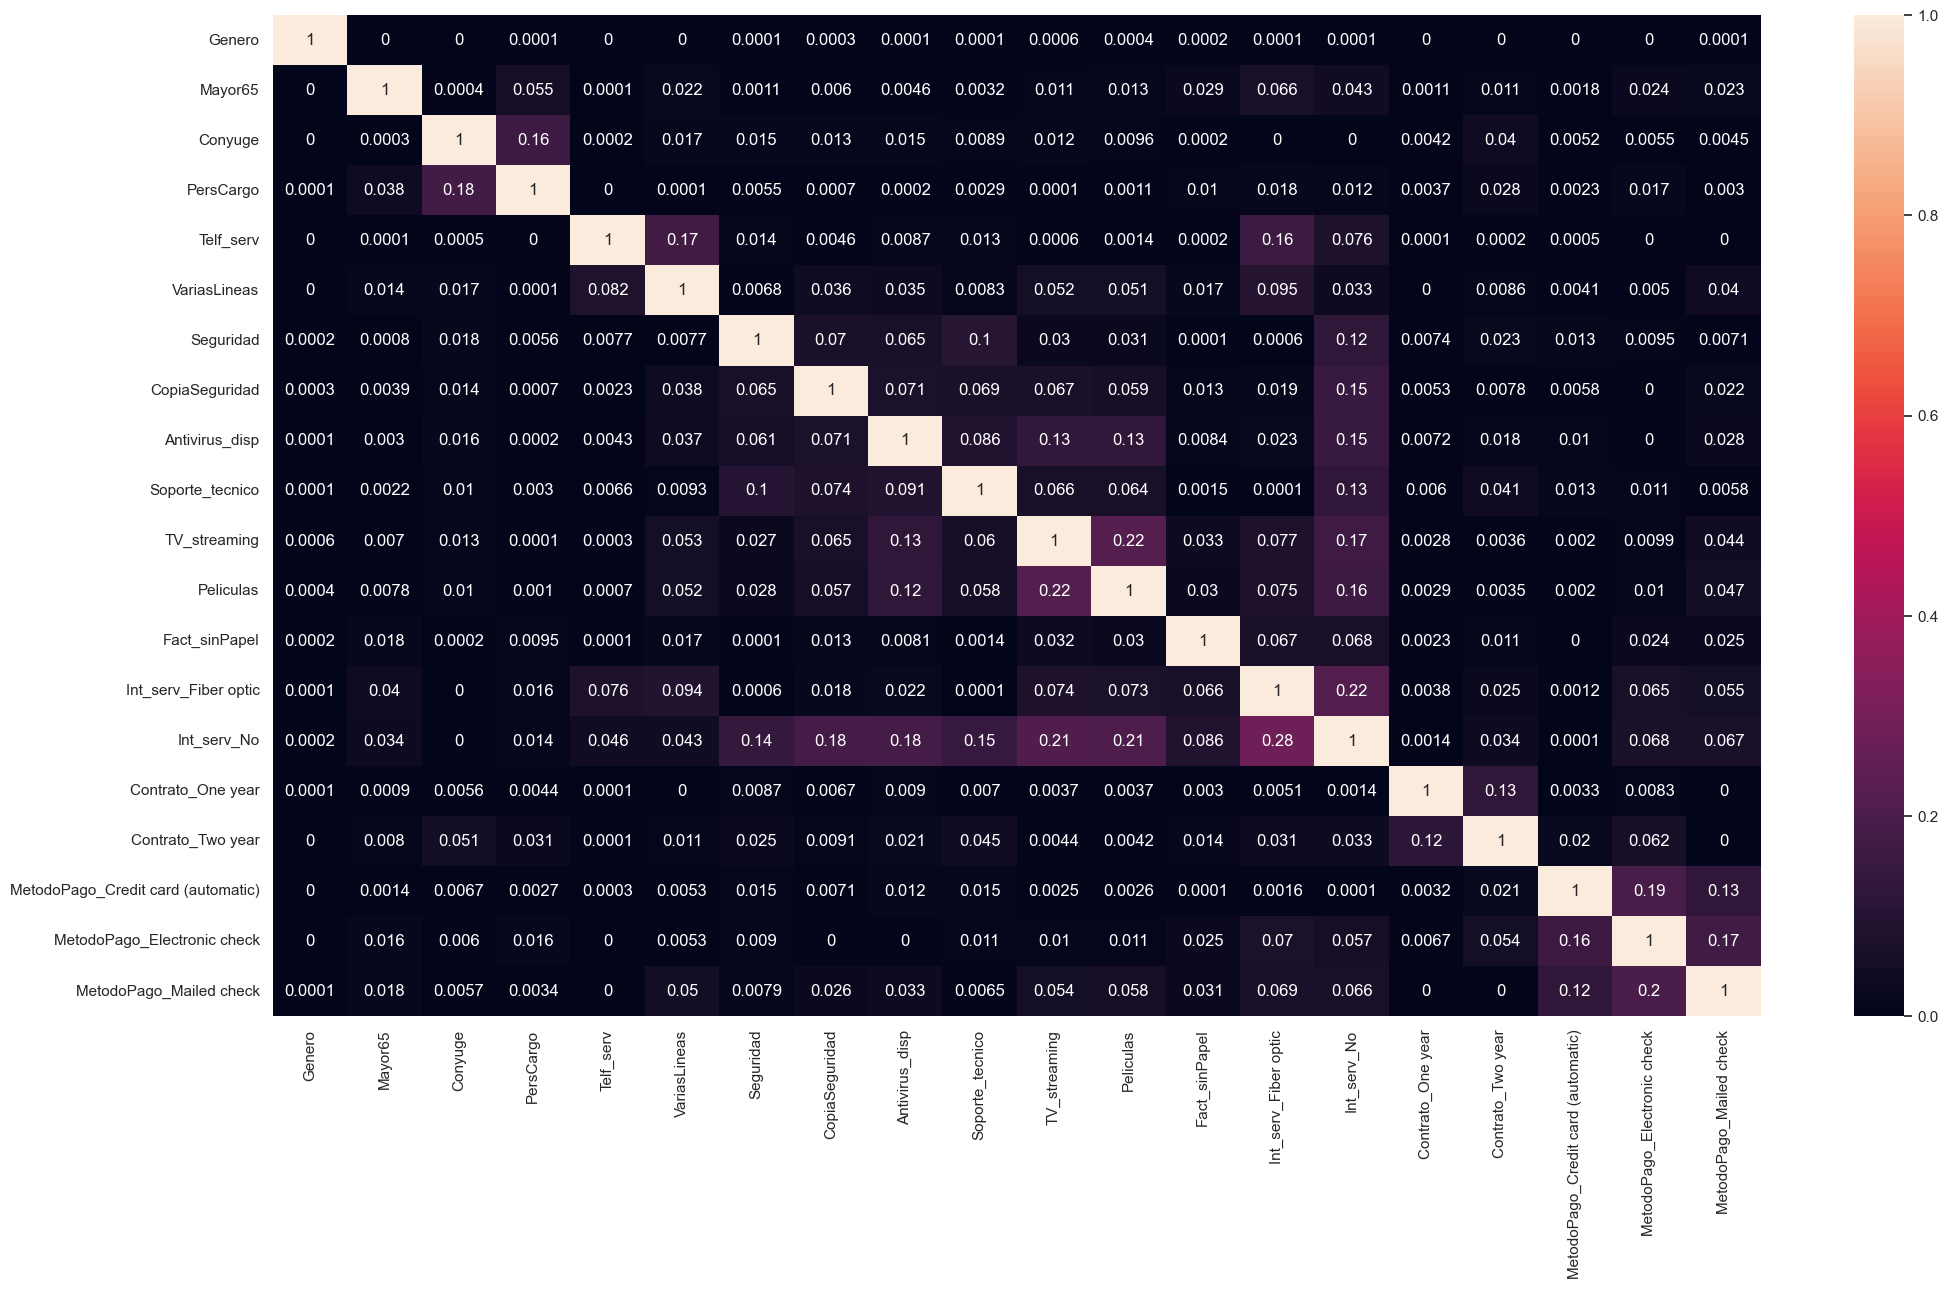

In [95]:
corr = NuestrasFunciones.get_cat_corr_mat(df_fuga_train.select_dtypes(exclude = np.number),tipo = "theils_u")
sns.set(rc={'figure.figsize':(24,13)})
sns.heatmap(corr, annot=True)

### La U de THeil es capaz de captar relaciones asimétricas entre dicotómicas.
### Es decir para la U de Theil PX|Y(x|y) =/=  PY|X(y|x).
### En este caso no vemos nada que llame la atención, todos los grados de asociación entre dicotómicas son bajos. 

<Axes: >

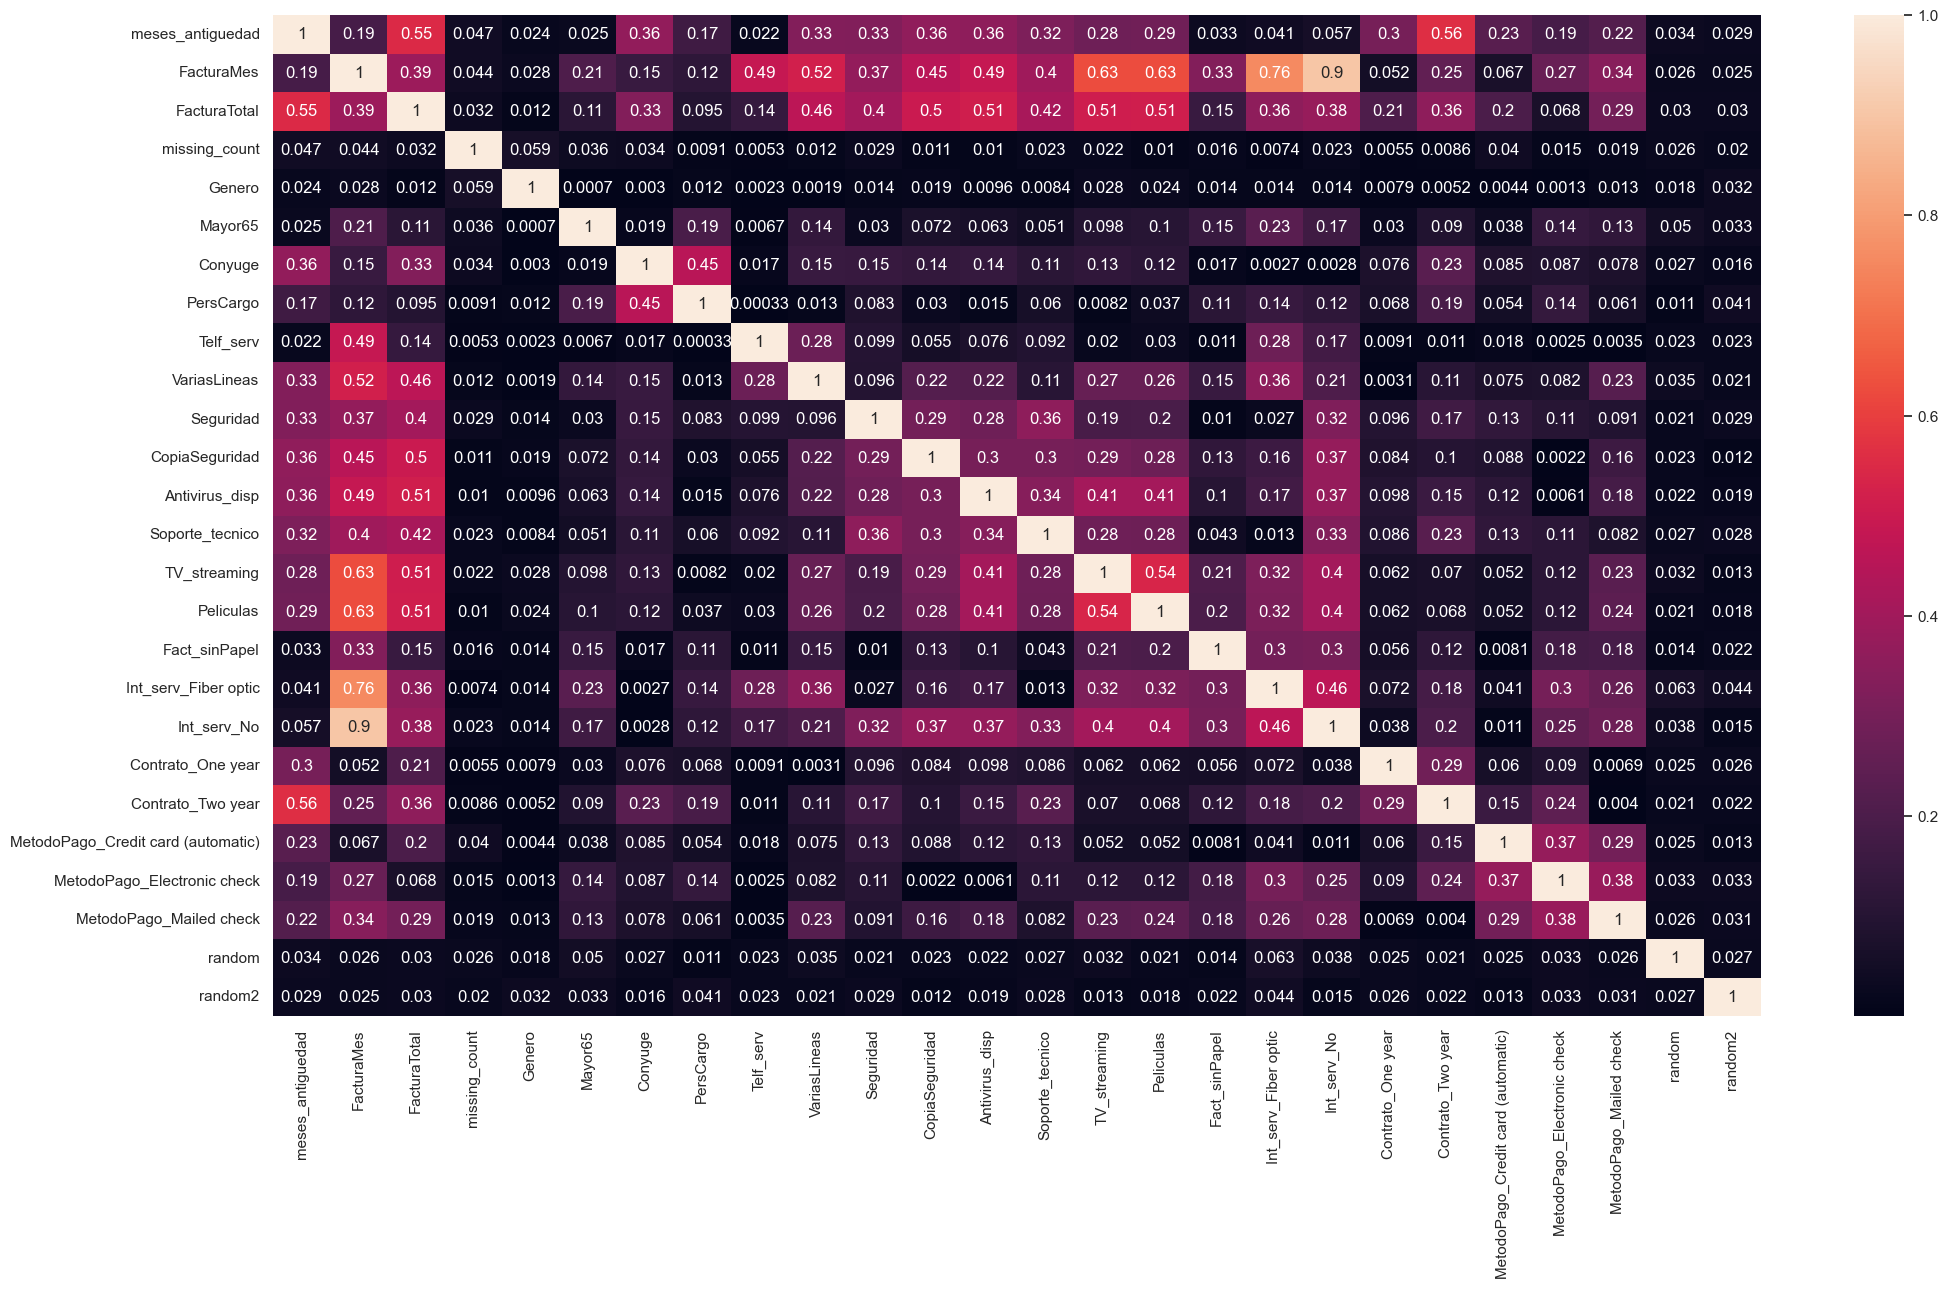

In [96]:
corr = NuestrasFunciones.get_cat_corr_mat(df_fuga_train,tipo = "cramer")
sns.set(rc={'figure.figsize':(24,13)})
sns.heatmap(corr, annot=True)

In [97]:
df_fuga_train.columns

Index(['meses_antiguedad', 'FacturaMes', 'FacturaTotal', 'missing_count',
       'Genero', 'Mayor65', 'Conyuge', 'PersCargo', 'Telf_serv',
       'VariasLineas', 'Seguridad', 'CopiaSeguridad', 'Antivirus_disp',
       'Soporte_tecnico', 'TV_streaming', 'Peliculas', 'Fact_sinPapel',
       'Int_serv_Fiber optic', 'Int_serv_No', 'Contrato_One year',
       'Contrato_Two year', 'MetodoPago_Credit card (automatic)',
       'MetodoPago_Electronic check', 'MetodoPago_Mailed check', 'random',
       'random2'],
      dtype='object')

La fuerte correlación de FacturaMes con ciertas variables categóricas tiene mucho sentido, investigaremos esto ahora más a fondo.

In [98]:
import statsmodels.api as sm

df_investigacion = df_fuga_train.select_dtypes(exclude = np.number)
df_investigacion. columns

df_investigacion.drop(["Genero","Mayor65","Conyuge","PersCargo","Fact_sinPapel","MetodoPago_Credit card (automatic)","MetodoPago_Electronic check","MetodoPago_Mailed check"], axis = 1, inplace = True)


df_investigacion.columns

Y_investigacion = df_fuga_train.FacturaMes

df_investigacion = sm.add_constant(df_investigacion)
results = sm.OLS(Y_investigacion,df_investigacion).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             FacturaMes   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     8419.
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:07:35   Log-Likelihood:                 516.81
No. Observations:                5082   AIC:                            -1008.
Df Residuals:                    5069   BIC:                            -922.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.3473 

### Debido al posterior uso de feature selector y pca decido comentar el drop de la variable

In [99]:
#df_fuga_train.drop("FacturaMes", axis = 1, inplace = True)

### Con ese R^2 y podemos estar seguros que al deshacernos de FacturaMes evitaremos problemas de colinearidad y no perderemos información importante

### Para empezar a tirar modelos me desharé de las columnas aleatorias y count_missings que ya vimos no tienen algún tipo de siginifcancnia

In [100]:
df_fuga_train.drop(["random","random2","missing_count"], axis = 1,inplace = True)
df_fuga_test.drop("missing_count", axis = 1,inplace = True)

### Modelo manual (le queda mucho camino)

In [101]:
df_manual = df_fuga_train.select_dtypes(include = np.number)
df_manual.columns

Index(['meses_antiguedad', 'FacturaMes', 'FacturaTotal'], dtype='object')

In [102]:
df_manual.columns

Index(['meses_antiguedad', 'FacturaMes', 'FacturaTotal'], dtype='object')

(1271, 15)
Optimization terminated successfully.
         Current function value: 0.413117
         Iterations 7
Scores in test:
Accuracy: 0.7907159716758458
Precision: 0.6163934426229508
Recall: 0.5578635014836796
F1 Score: 0.5856697819314641

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       934
         1.0       0.62      0.56      0.59       337

    accuracy                           0.79      1271
   macro avg       0.73      0.72      0.72      1271
weighted avg       0.78      0.79      0.79      1271



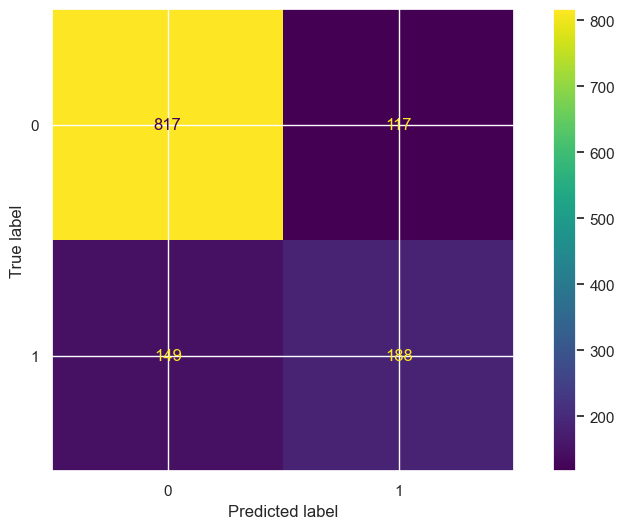

In [103]:
df_manual = df_fuga_train.drop(["FacturaMes","FacturaTotal","Genero","Conyuge","Antivirus_disp","MetodoPago_Credit card (automatic)","PersCargo","MetodoPago_Mailed check"], axis = 1)
df_test_manual = df_fuga_test.drop(["FacturaMes","FacturaTotal","Genero","Conyuge","Antivirus_disp","MetodoPago_Credit card (automatic)","PersCargo","MetodoPago_Mailed check"], axis = 1)

print(df_test_manual.shape)
df_manual.columns

Y_manual = Y_train

df_manual = sm.add_constant(df_manual)
df_test_manual = sm.add_constant(df_test_manual)
results = sm.Logit(Y_manual,df_manual).fit()

#print(results.summary())

predictions = results.predict(df_test_manual)
predictions = list(map(round, predictions)) 


accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
print("Scores in test:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()


In [104]:
# Modelo manual 1 da accuracy 0.7883556254917388 || F1 Score: 0.58678955453149

### Modelo Gridsearch

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.8095188187429422
Scores in test:
Accuracy: 0.7977970102281668
Precision: 0.6333333333333333
Recall: 0.5637982195845698
F1 Score: 0.5965463108320251

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87       934
         1.0       0.63      0.56      0.60       337

    accuracy                           0.80      1271
   macro avg       0.74      0.72      0.73      1271
weighted avg       0.79      0.80      0.79      1271



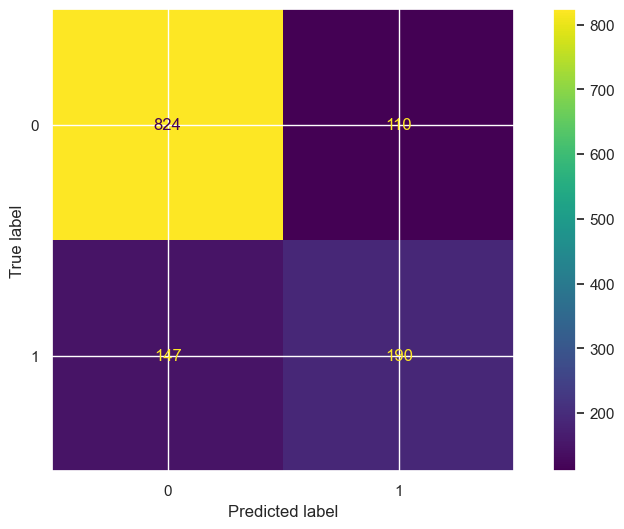

In [106]:
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
#df_fuga_test.drop(["FacturaMes","FacturaTotal","missing_count"],axis = 1, inplace = True)
#df_fuga_test.drop("missing_count",axis = 1, inplace = True)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : [0.001, 0.01, 0.1, 1, 10, 100],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
logreg = LogisticRegression()
grid_search = GridSearchCV(logreg, 
                   param_grid = parameters,
                   scoring = 'accuracy', 
                   cv = 10)

grid_search.fit(df_fuga_train,Y_train)
print("Tuned Hyperparameters :", grid_search.best_params_)
print("Accuracy :",grid_search.best_score_)

predictions = grid_search.predict(df_fuga_test)
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
print("Scores in test:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()

### Modelo con feature selection automático


Sequential Forward + Best Selection:
['meses_antiguedad', 'FacturaTotal', 'PersCargo', 'Telf_serv', 'VariasLineas', 'CopiaSeguridad', 'Soporte_tecnico', 'TV_streaming', 'Fact_sinPapel', 'Int_serv_Fiber optic', 'Int_serv_No', 'Contrato_One year', 'MetodoPago_Credit card (automatic)', 'MetodoPago_Electronic check', 'MetodoPago_Mailed check']
CV Score:
0.8142438528779496
Scores in test:
Accuracy: 0.7859952793076318
Precision: 0.6156583629893239
Recall: 0.5133531157270029
F1 Score: 0.5598705501618123

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86       934
         1.0       0.62      0.51      0.56       337

    accuracy                           0.79      1271
   macro avg       0.73      0.70      0.71      1271
weighted avg       0.78      0.79      0.78      1271



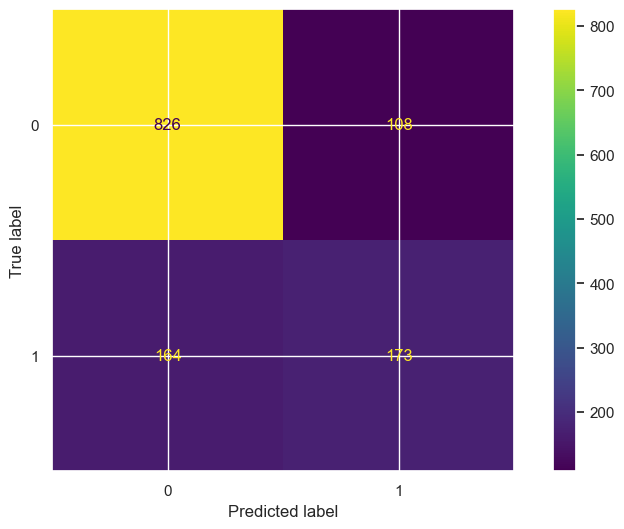

In [107]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

sfs__int_best = sfs(logreg, 
          k_features='best', 
          forward=False, 
          floating=True, 
          scoring='accuracy',
          cv=4,n_jobs=-1)

sfs__int_best.fit(df_fuga_train, Y_train)

print('\nSequential Forward + Best Selection:')
best_features = list(sfs__int_best.k_feature_names_)
print(best_features)
print('CV Score:')
print(sfs__int_best.k_score_)

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : [0.001, 0.01, 0.1, 1, 10, 100],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
grid_search_back = GridSearchCV(logreg, 
                   param_grid = parameters,
                   scoring = 'accuracy', 
                   cv = 10)

grid_search_back.fit(df_fuga_train[best_features],Y_train)


predictions = grid_search_back.predict(df_fuga_test[best_features])
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
print("Scores in test:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [108]:
# forward=True da 0.7891424075531078 || F1 Score: 0.5691318327974276
# forward=False da 0.79228 || F1 Score: 0.5782747603833865

### Modelo con interacciones y selección automática de variables

In [109]:
from sklearn.preprocessing import PolynomialFeatures
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

df_fuga_train_interac = pd.DataFrame(interaction.fit_transform(df_fuga_train), columns=interaction.get_feature_names_out(input_features=df_fuga_train.columns))
df_fuga_train_interac = df_fuga_train_interac.loc[:, df_fuga_train_interac.var() != 0.0]

#df_fuga_train_interac


In [110]:
solo_interac = [i for i in df_fuga_train_interac if i not in df_fuga_train]
df_SoloInterac = df_fuga_train_interac[solo_interac]

to_factor = list(df_SoloInterac.loc[:,df_SoloInterac.nunique() <= 4]);  
df_SoloInterac[to_factor] = df_SoloInterac[to_factor].astype('category')
print(f"cantidad de columnas considerando todas las interacciones: {len(solo_interac)}!!!")
print(f"cantidad de observaciones: {df_SoloInterac.shape[0]}")
df_SoloInterac = df_SoloInterac.select_dtypes(exclude = np.number)
x = df_SoloInterac.apply(lambda x: sum(x))
to_keep = x.sort_values(ascending = False).head(30).index
print("Nos quedamos sólo con las 30 interacciones que tienen más prevalencia de 1s")
to_keep = list(to_keep) + list(df_fuga_train.columns)

cantidad de columnas considerando todas las interacciones: 248!!!
cantidad de observaciones: 5082
Nos quedamos sólo con las 30 interacciones que tienen más prevalencia de 1s


In [111]:
df_fuga_train_interac = df_fuga_train_interac[to_keep]

df_fuga_test_interac = pd.DataFrame(interaction.fit_transform(df_fuga_test), columns=interaction.get_feature_names_out(input_features=df_fuga_test.columns))
df_fuga_test_interac = df_fuga_test_interac.loc[:, df_fuga_test_interac.var() != 0.0]


df_fuga_test_interac = df_fuga_test_interac[to_keep]


Sequential Forward + Best Selection:
['Telf_serv Int_serv_Fiber optic', 'Fact_sinPapel Int_serv_Fiber optic', 'Genero Fact_sinPapel', 'TV_streaming Peliculas', 'VariasLineas Int_serv_Fiber optic', 'CopiaSeguridad Fact_sinPapel', 'Fact_sinPapel MetodoPago_Electronic check', 'meses_antiguedad', 'FacturaTotal', 'Genero', 'Telf_serv', 'CopiaSeguridad', 'Fact_sinPapel', 'Int_serv_Fiber optic', 'Contrato_One year']
CV accuracy for feature selection:
0.816016745448125
Tuned Hyperparameters : {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
CV accuracy in grid search: 0.6059797837508019
scores in test: 
Accuracy: 0.7891424075531078
Precision: 0.6219081272084805
Recall: 0.5222551928783383
F1 Score: 0.567741935483871

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       934
         1.0       0.62      0.52      0.57       337

    accuracy                           0.79      1271
   macro avg       0.73      0.70     

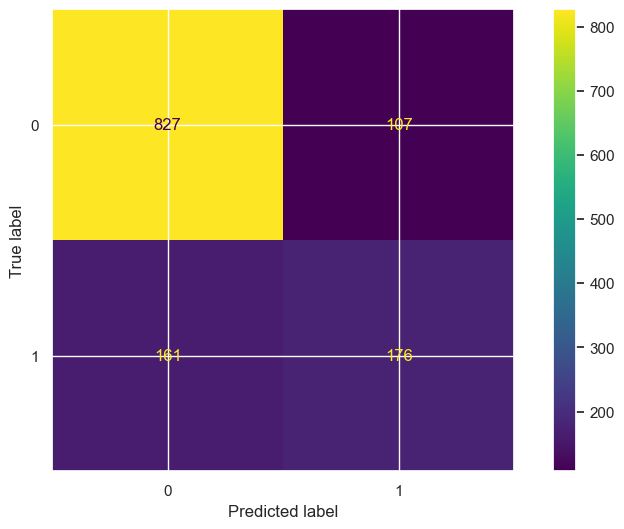

In [112]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 100000000)

sfs_backw_int_best = sfs(logreg, 
          k_features="best", 
          forward=False, 
          floating=True, 
          scoring='accuracy',
          cv=4,n_jobs=-1)

sfs_backw_int_best = sfs_backw_int_best.fit(df_fuga_train_interac, Y_train)

print('\nSequential Forward + Best Selection:')
best_features_interac = list(sfs_backw_int_best.k_feature_names_)
print(best_features_interac)
print('CV accuracy for feature selection:')
print(sfs_backw_int_best.k_score_)


parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : [0.001, 0.01, 0.1, 1, 10, 100],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
grid_search_inter = GridSearchCV(logreg, 
                   param_grid = parameters,
                   scoring = 'f1', 
                   cv = 4)


best_model = df_fuga_train_interac[best_features_interac]
grid_search_inter.fit(best_model,Y_train)
print("Tuned Hyperparameters :", grid_search_inter.best_params_)
print("CV accuracy in grid search:",grid_search_inter.best_score_)


predictions = grid_search_inter.predict(df_fuga_test_interac[best_features_interac])
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print("scores in test: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [113]:
#Forward=False da Accuracy con 30: 0.7923 || F1 Score: 0.5835962145110412
#Forward=True da Accuracy con 30: 0.7883556254917388 || F1 Score: 0.5682182985553772

Tuned Hyperparameters : {'logreg__C': 0.001, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear', 'pca__n_components': 0.6}
CV accuracy in grid search: 0.597579300425067
scores in test: 
Accuracy: 0.7741935483870968
Precision: 0.5615763546798029
Recall: 0.6765578635014837
F1 Score: 0.6137281292059219

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       934
         1.0       0.56      0.68      0.61       337

    accuracy                           0.77      1271
   macro avg       0.72      0.74      0.73      1271
weighted avg       0.79      0.77      0.78      1271



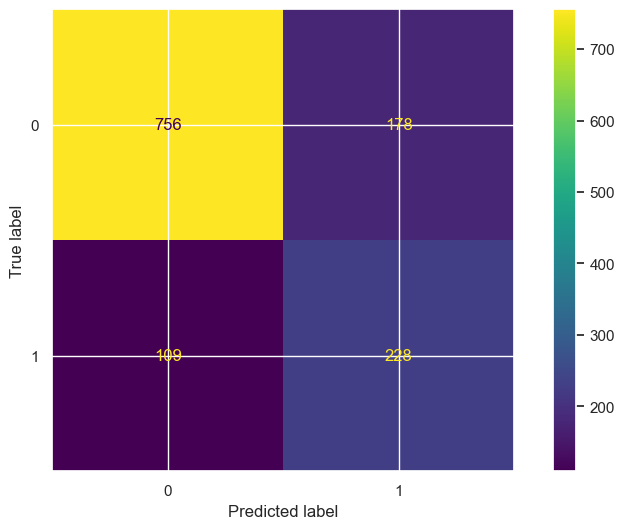

In [114]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(max_iter = 100000000)
pca = PCA()

parameters = {
    "pca__n_components": [0.6, 0.8],
    'logreg__penalty' : ['l1','l2'], 
    'logreg__C'       : [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver'  : ['newton-cg', 'lbfgs', 'liblinear']
}
pipe_model_interac = Pipeline(steps=[("pca", pca), ("logreg", logreg)])

grid_search_inter_pca = GridSearchCV(pipe_model_interac, 
                   param_grid = parameters,
                   scoring = 'f1', 
                   cv = 4)



grid_search_inter_pca.fit(df_fuga_train_interac,Y_train)
print("Tuned Hyperparameters :", grid_search_inter_pca.best_params_)
print("CV accuracy in grid search:",grid_search_inter_pca.best_score_)


predictions = grid_search_inter_pca.predict(df_fuga_test_interac)
accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

print("scores in test: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print()

print("Classification Report:")
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test, predictions)
plt.rcParams["figure.figsize"] = (10, 6)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
#Con PCA peor accuracy, pero mejor F1, mucho más balanceado entre FN y FP aunque la proporción de false positive sigue siendo muy alta 